In [1]:
import scanpy as sc
import os
import numpy as np
import seaborn
import matplotlib
import pandas as pd
import sys
import scipy
import tqdm
import matplotlib.pyplot as plt

sys.path.append('/home/matthew.schmitz/utils/mts-utils/')
from genomics import sc_analysis
# sys.path.append('/home/matthew.schmitz/Matthew/code/scANTIPODE/')
import antipode
import antipode.antipode_model
import antipode.model_functions
import antipode.model_distributions
import antipode.model_modules
import antipode.train_utils
import antipode.plotting
sc.settings.figdir=os.path.expanduser('~/WbFigures/DevFinalAnalysis')


/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
MDE_KEY='X_antipode_UMAP'
leaf_key = 'level_2'
discov_key = 'species'
layer_key = 'spliced'
model_tag   = '1.9.1.8.5_Dev_final_600clusters'


In [3]:
adata=sc.read_h5ad('/home/matthew.schmitz/Matthew/models/'+model_tag+'/p3_adata.h5ad',backed='r')
# adata=sc.read_h5ad('/home/matthew.schmitz/Matthew/models/'+model_tag+'/analysis_inprogress.h5ad',backed='r')

In [4]:
adata.obs.index=adata.obs.index.to_series().str.replace('-[0-9]+$','',regex=True).str.replace('-[0-9]+$','',regex=True)

In [5]:
curateds=pd.read_csv('/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/data/taxtest/annotations/curated_class.txt',index_col=0)
curateds=curateds.rename({leaf_key:'anno_level_2'},axis=1)
#adata.obs.loc[:,curateds.columns]=adata.obs.loc[:,curateds.columns].astype('string')
adata.obs.loc[:,curateds.columns]=curateds.astype('string')
adata.obs['female']=adata.obs['batch_name'].replace(pd.read_csv('/home/matthew.schmitz/Matthew/data/taxtest/annotations/inferred_sex.csv',index_col=0).to_dict()['female'])

/scratch/fast/1725836/ipykernel_2805060/153555327.py:5: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  adata.obs['female']=adata.obs['batch_name'].replace(pd.read_csv('/home/matthew.schmitz/Matthew/data/taxtest/annotations/inferred_sex.csv',index_col=0).to_dict()['female'])


# LaManno Labels

In [6]:
linnarson_labels=pd.read_csv('/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/data/taxtest/extra/mousefastqpool/SRP135960_linnarson_adultmouse/annotations/unambiguous_metadata_renamed.csv',index_col=0)

In [7]:
linnarson_labels.index = list(linnarson_labels.index.to_series().str.replace('-[0-9]+$','',regex=True))

In [8]:
linnarson_labels=linnarson_labels.loc[linnarson_labels.index.isin(adata.obs.index),:]

In [9]:
linnarson_labels

n_genes  \
GACGTAACGATAAG_e10.0_Forebrain_SRR11947585             5416   
GCAGCCGATCCTCG_e10.0_Forebrain_SRR11947585             5387   
GGGTAACTGACAGG_e10.0_Forebrain_SRR11947585             5140   
GTCGAATGGTGCTA_e10.0_Forebrain_SRR11947585             5508   
ATTGCGGAATCAGC_e10.0_Forebrain_SRR11947585             5493   
...                                                     ...   
ATCACTTGTGGGAG_e18.0_ForebrainVentroLateral_SRR...      856   
ATTCGGGAACGGTT_e18.0_ForebrainVentroLateral_SRR...      804   
ATGCAGACGGATTC_e18.0_ForebrainVentroLateral_SRR...      924   
AATGAGGATGTCGA_e18.0_ForebrainVentroLateral_SRR...      902   
GAAATACTTGGTTG_e18.0_ForebrainVentroLateral_SRR...      866   

                                                                                  batch_name  \
GACGTAACGATAAG_e10.0_Forebrain_SRR11947585                       e10.0_Forebrain_SRR11947585   
GCAGCCGATCCTCG_e10.0_Forebrain_SRR11947585                       e10.0_Forebrain_SRR11947585   
GGGTAACTGACAGG_e10.0_Forebrain_SRR11947585                       e10.0_Forebrain_SRR11947585   
GTCGAATGGTGCTA_e10.0_Forebrain_SRR11947585                       e10.0_Forebrain_SRR11947585   
ATTGCGGAATCAGC_e10.0_Forebrain_SRR11947585                       e10.0_Forebrain_SRR11947585   
...                                                                                      ...   
ATCACTTGTGGGAG_e18.0_ForebrainVentroLateral_SRR...  e18.0_ForebrainVentroLateral_SRR11947657   
ATTCGGGAACGGTT_e18.0_ForebrainVentroLateral_SRR...  e18.0_ForebrainVentroLateral_SRR11947657   
ATGCAGACGGATTC_e18.0_ForebrainVentroLateral_SRR...  e18.0_ForebrainVentroLateral_SRR11947657   
AATGAGGATGTCGA_e18.0_ForebrainVentroLateral_SRR...  e18.0_ForebrainVentroLateral_SRR11947657   
GAAATACTTGGTTG_e18.0_ForebrainVentroLateral_SRR...  e18.0_ForebrainVentroLateral_SRR11947657   

                                                                    dataset_name  \
GACGTAACGATAAG_e10.0_Forebrain_SRR11947585          PRJNA637987_lamanno_devmouse   
GCAGCCGATCCTCG_e10.0_Forebrain_SRR11947585          PRJNA637987_lamanno_devmouse   
GGGTAACTGACAGG_e10.0_Forebrain_SRR11947585          PRJNA637987_lamanno_devmouse   
GTCGAATGGTGCTA_e10.0_Forebrain_SRR11947585          PRJNA637987_lamanno_devmouse   
ATTGCGGAATCAGC_e10.0_Forebrain_SRR11947585          PRJNA637987_lamanno_devmouse   
...                                                                          ...   
ATCACTTGTGGGAG_e18.0_ForebrainVentroLateral_SRR...  PRJNA637987_lamanno_devmouse   
ATTCGGGAACGGTT_e18.0_ForebrainVentroLateral_SRR...  PRJNA637987_lamanno_devmouse   
ATGCAGACGGATTC_e18.0_ForebrainVentroLateral_SRR...  PRJNA637987_lamanno_devmouse   
AATGAGGATGTCGA_e18.0_ForebrainVentroLateral_SRR...  PRJNA637987_lamanno_devmouse   
GAAATACTTGGTTG_e18.0_ForebrainVentroLateral_SRR...  PRJNA637987_lamanno_devmouse   

                                                    timepoint region  \
GACGTAACGATAAG_e10.0_Forebrain_SRR11947585                 10     FB   
GCAGCCGATCCTCG_e10.0_Forebrain_SRR11947585                 10     FB   
GGGTAACTGACAGG_e10.0_Forebrain_SRR11947585                 10     FB   
GTCGAATGGTGCTA_e10.0_Forebrain_SRR11947585                 10     FB   
ATTGCGGAATCAGC_e10.0_Forebrain_SRR11947585                 10     FB   
...                                                       ...    ...   
ATCACTTGTGGGAG_e18.0_ForebrainVentroLateral_SRR...         18     FB   
ATTCGGGAACGGTT_e18.0_ForebrainVentroLateral_SRR...         18     FB   
ATGCAGACGGATTC_e18.0_ForebrainVentroLateral_SRR...         18     FB   
AATGAGGATGTCGA_e18.0_ForebrainVentroLateral_SRR...         18     FB   
GAAATACTTGGTTG_e18.0_ForebrainVentroLateral_SRR...         18     FB   

                                                    clean_cellname  \
GACGTAACGATAAG_e10.0_Forebrain_SRR11947585          GACGTAACGATAAG   
GCAGCCGATCCTCG_e10.0_Forebrain_SRR11947585          GCAGCCGATCCTCG   
GGGTAACTGACAGG_e10.0_Forebrain_SRR11947585          GGGTAA

In [10]:
cols=dict(zip(["Class","Subclass","ClusterName"],["lamanno_class","lamanno_subclass","lamanno_cluster"]))#linnarson_labels.columns[~linnarson_labels.columns.isin(adata.obs.columns)]
for k in cols.keys():
    try:
        adata.obs[k] = adata.obs[k].astype(str)
    except:
        pass
adata.obs.loc[linnarson_labels.index,cols.keys()]=linnarson_labels.loc[:,cols.keys()]
adata.obs.rename(columns=cols,inplace=True)

In [11]:
# sc.pl.embedding(
#     adata,
#     basis=MDE_KEY,
#     color=["lamanno_class","lamanno_subclass","lamanno_cluster"],
#     palette=sc.pl.palettes.godsnot_102
# )


In [12]:
adata.obs = adata.obs.loc[:,~adata.obs.columns.duplicated()]

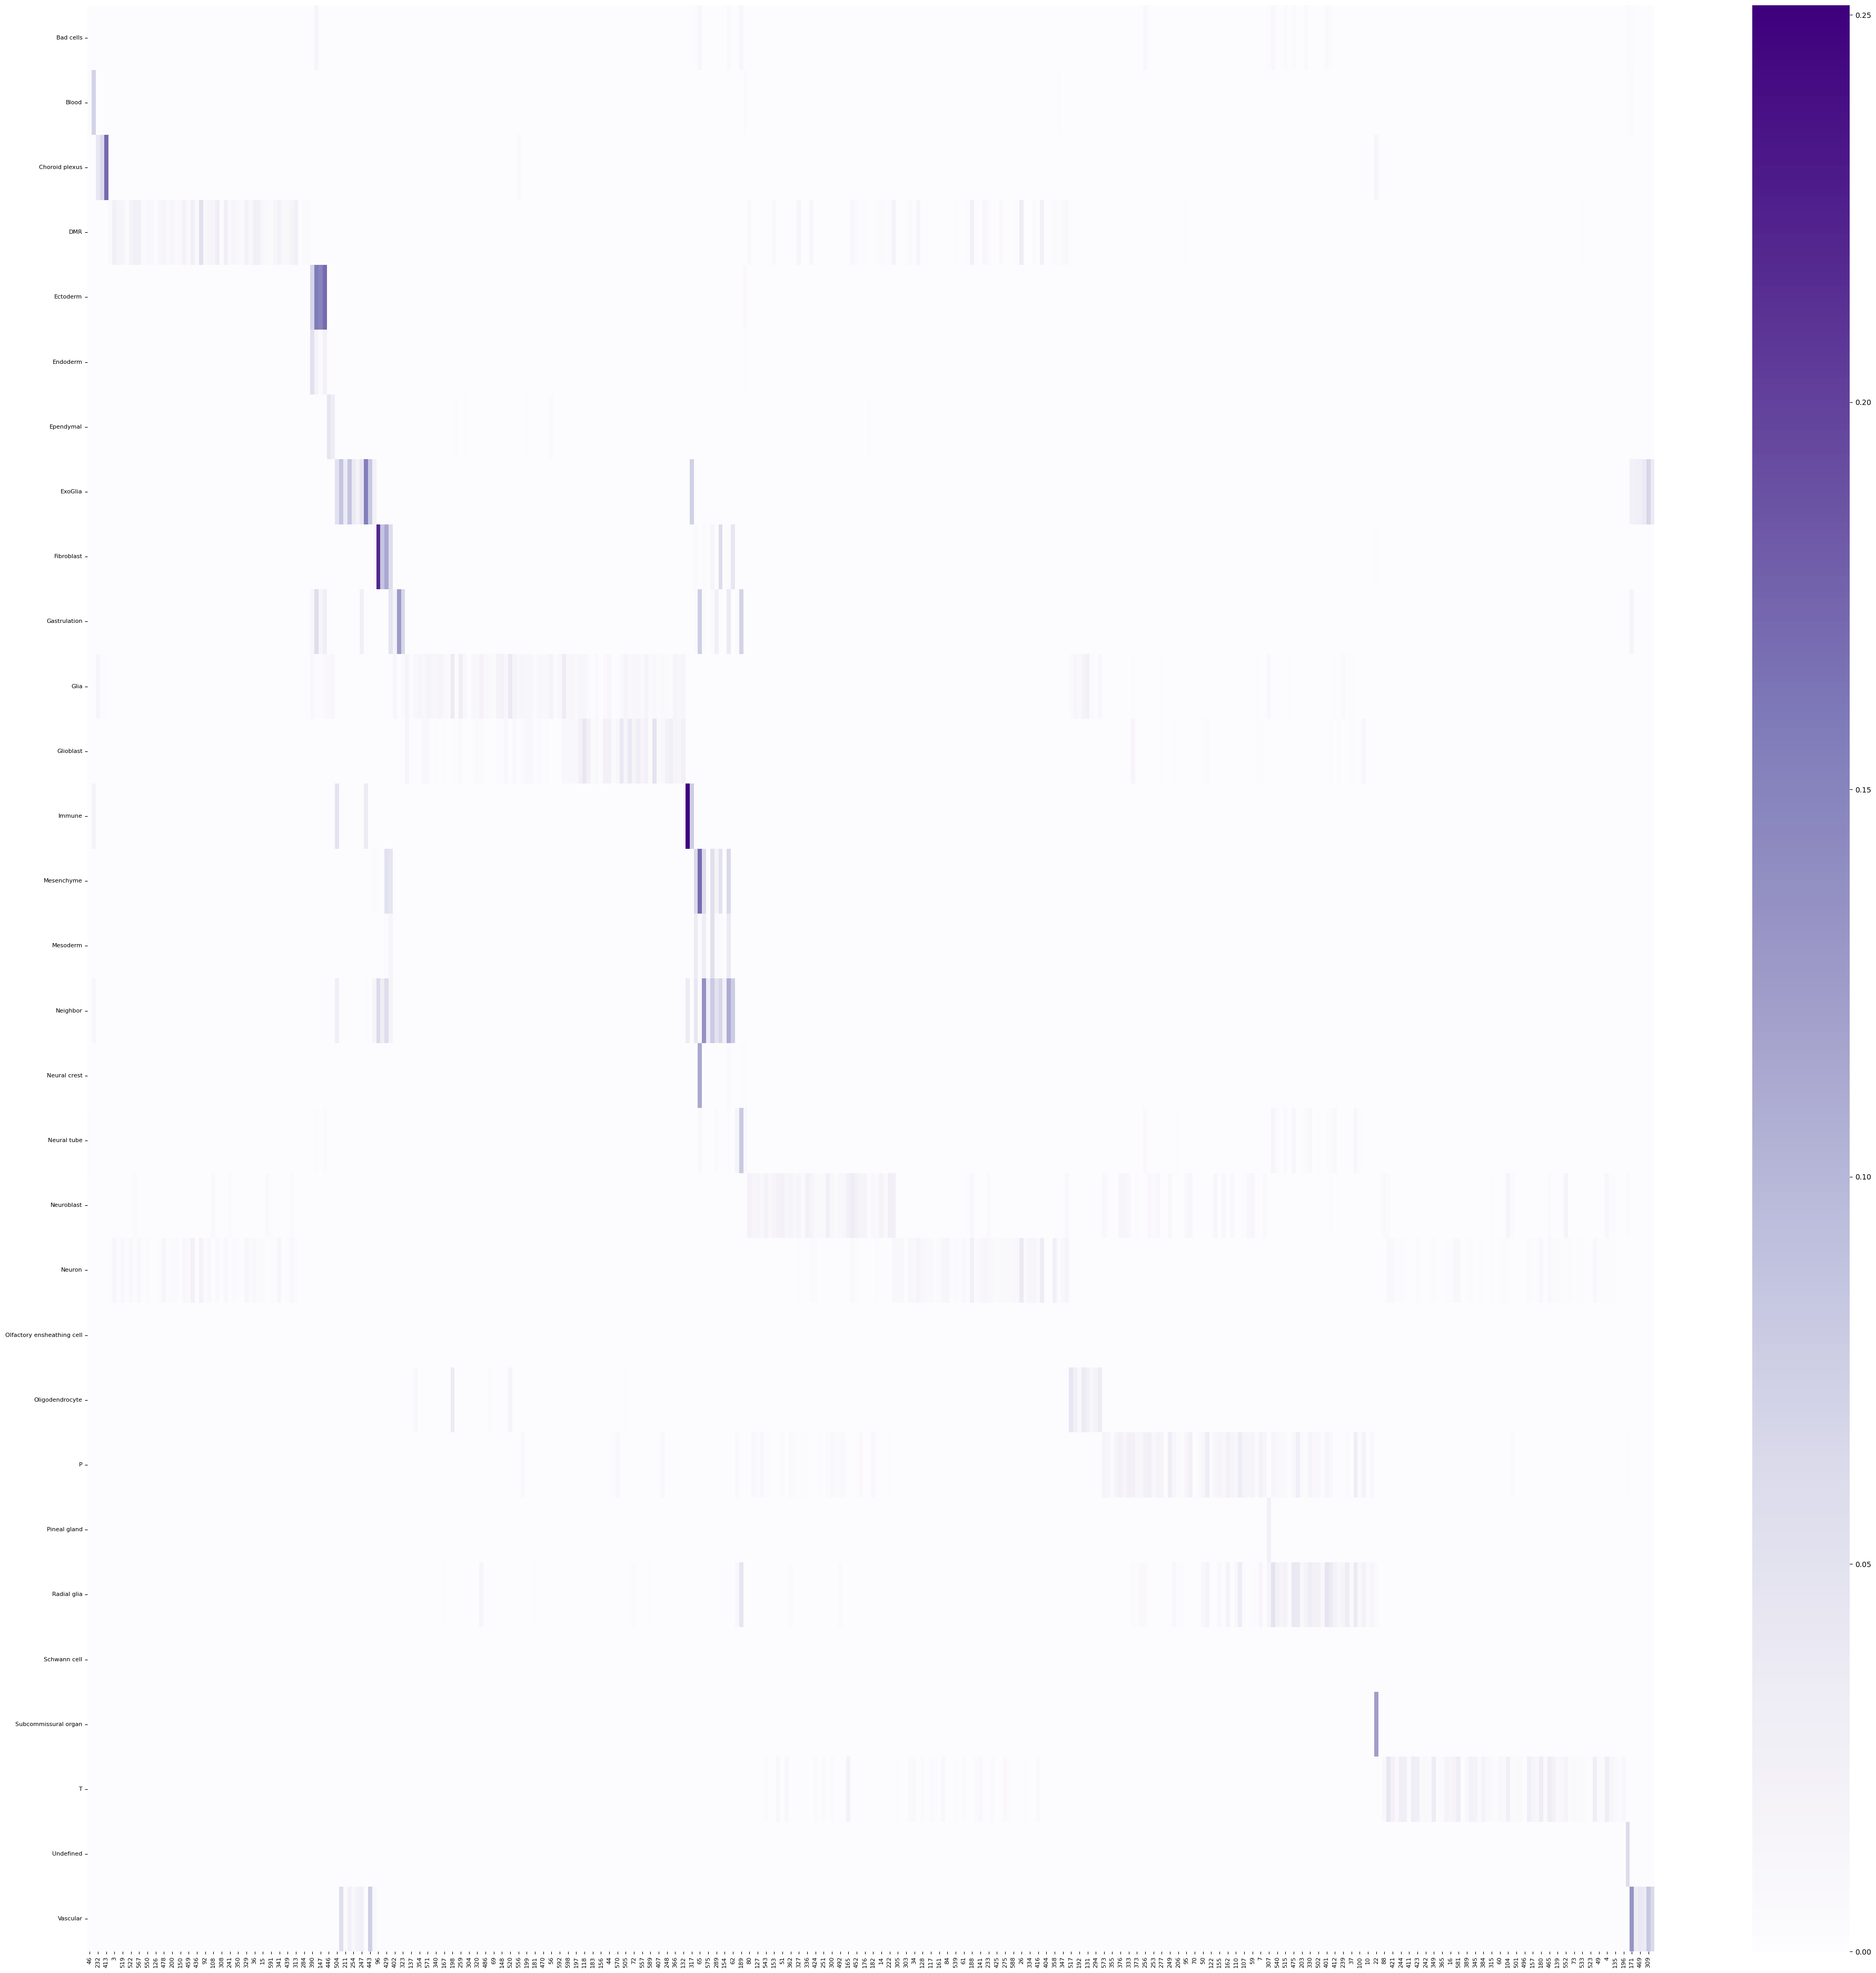

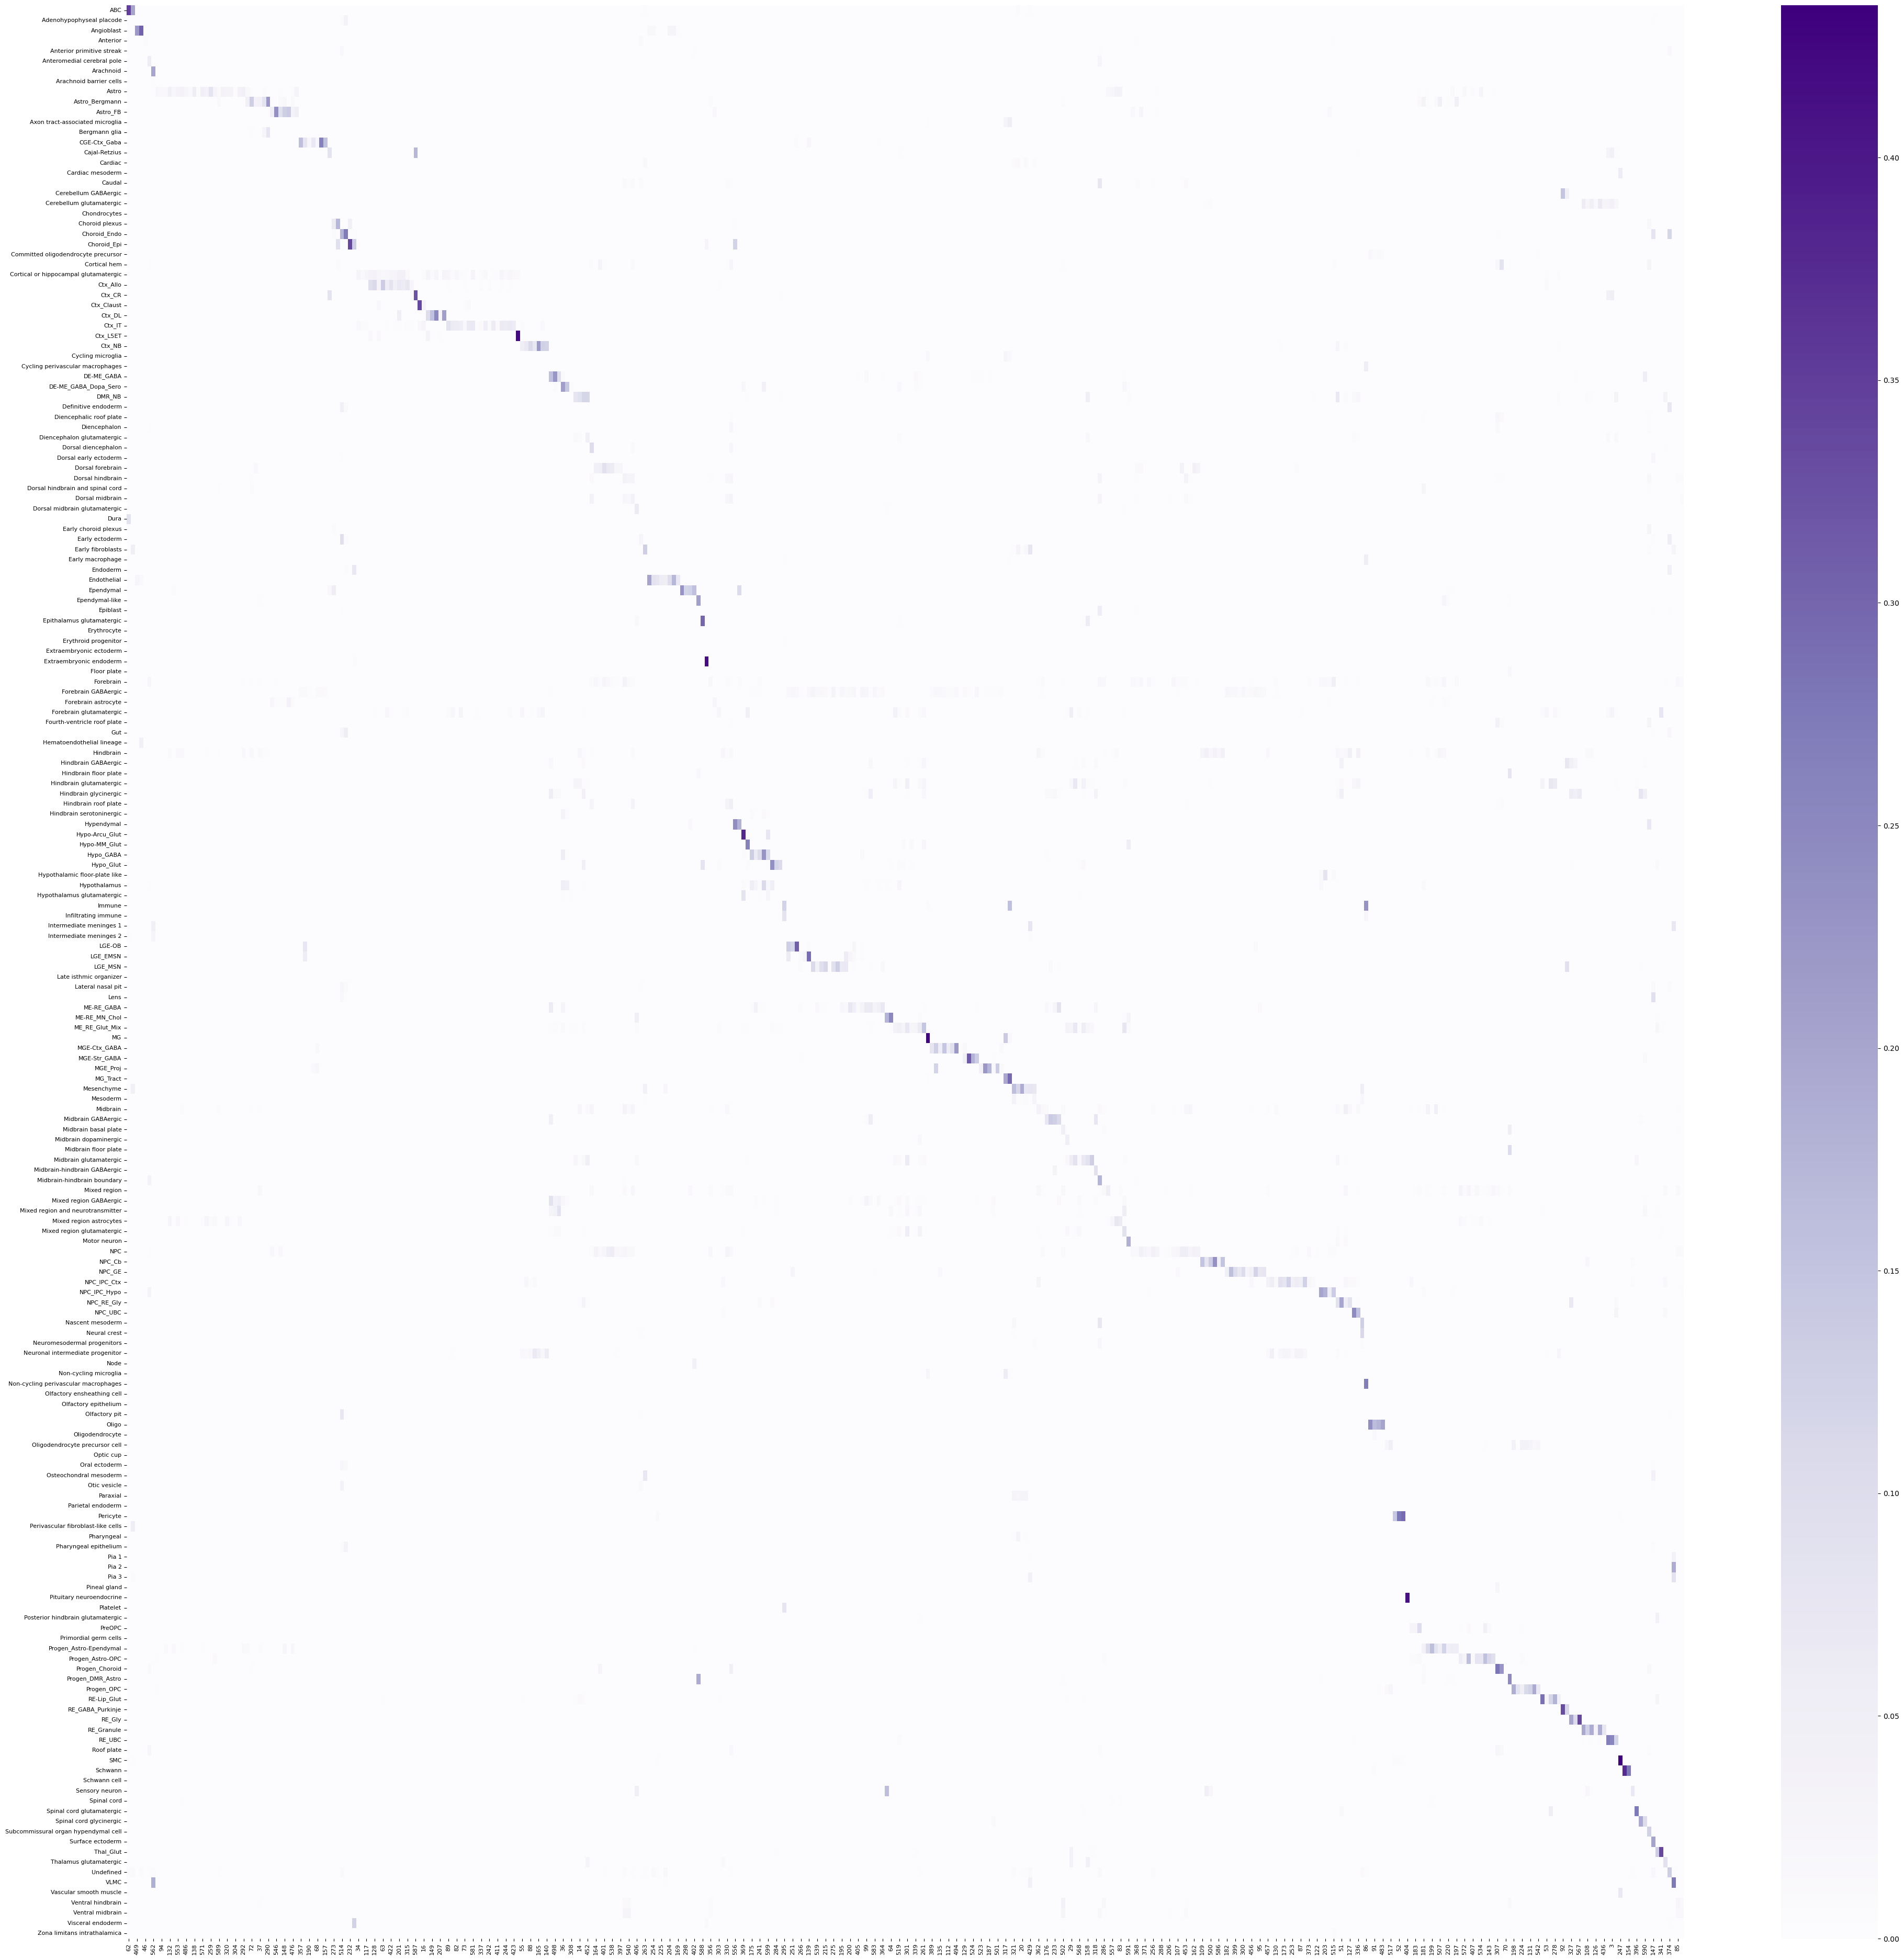

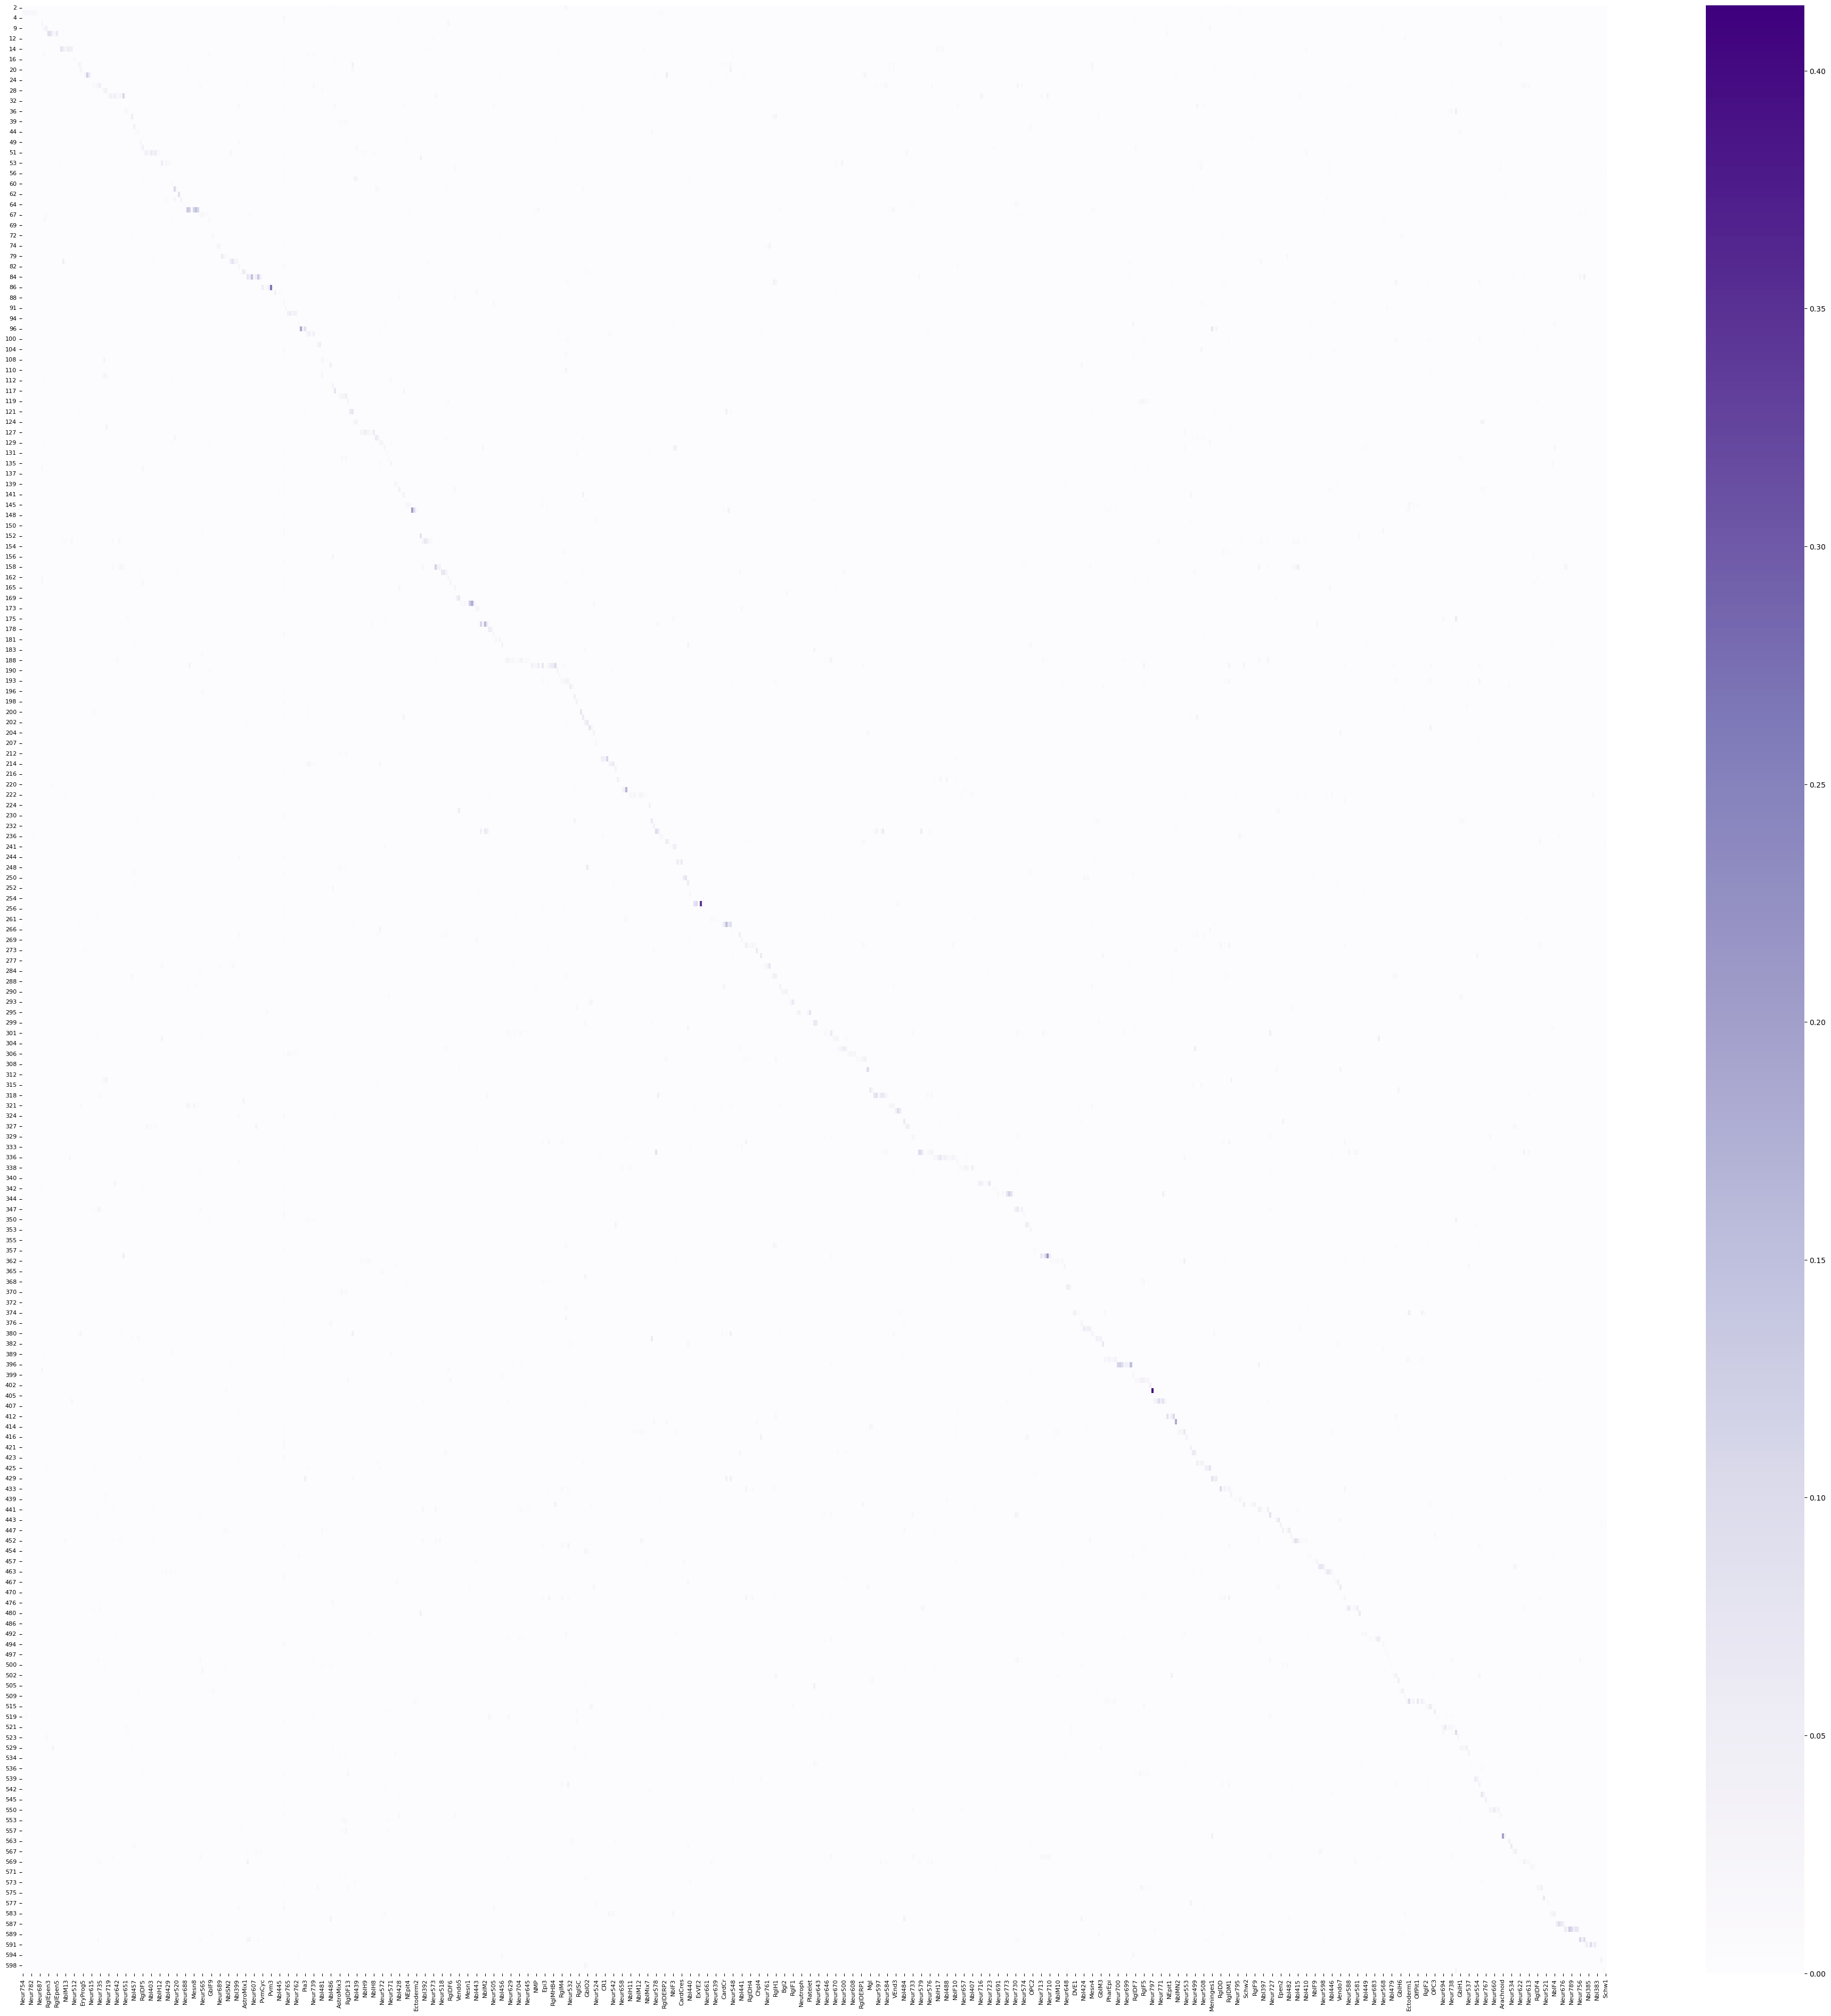

In [13]:
sc_analysis.create_heatmap(sc_analysis.get_cross_category_jaccard(adata.obs,'lamanno_class',leaf_key),cmap='Purples')
sc_analysis.create_heatmap(sc_analysis.get_cross_category_jaccard(adata.obs,'lamanno_subclass',leaf_key),cmap='Purples')
sc_analysis.create_heatmap(sc_analysis.get_cross_category_jaccard(adata.obs,leaf_key,'lamanno_cluster'),cmap='Purples')

In [14]:
xcj=sc_analysis.get_cross_category_jaccard(adata.obs,'lamanno_subclass',leaf_key)

In [15]:
adata.obs['linnarson_extended']=adata.obs[leaf_key].replace(adata.obs.groupby(leaf_key)['lamanno_subclass'].value_counts().unstack().idxmax(1).to_dict())

/scratch/fast/1725836/ipykernel_2805060/2888605536.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata.obs['linnarson_extended']=adata.obs[leaf_key].replace(adata.obs.groupby(leaf_key)['lamanno_subclass'].value_counts().unstack().idxmax(1).to_dict())
/scratch/fast/1725836/ipykernel_2805060/2888605536.py:1: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  adata.obs['linnarson_extended']=adata.obs[leaf_key].replace(adata.obs.groupby(leaf_key)['lamanno_subclass'].value_counts().unstack().idxmax(1).to_dict())


In [16]:
# sc.pl.embedding(
#     adata,
#     basis=MDE_KEY,
#     color=["linnarson_extended",leaf_key],
#     palette=sc.pl.palettes.godsnot_102,
#     legend_loc='on data'
# )

# sc.pl.embedding(
#     adata,
#     basis=MDE_KEY,
#     color=["linnarson_extended"],
#     palette=sc.pl.palettes.godsnot_102
# )


In [17]:
in_obs=pd.read_csv('/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/data/taxtest/HvQvM/annotations/GSE169122_obs.csv.gz',index_col=0)
inds=adata.obs.index.str.replace(r'-\d+$', '', regex=True).str.replace(r'-\d+$', '', regex=True)
get_inds=inds[inds.isin(in_obs.index)]
adata.obs.loc[adata.obs.index[inds.isin(in_obs.index)],'initial_class']=list(in_obs.loc[adata.obs.index[inds.isin(in_obs.index)].str.replace(r'-\d+$', '', regex=True).str.replace(r'-\d+$', '', regex=True),'class'])
counts=adata.obs.groupby(leaf_key)['initial_class'].value_counts().unstack()
# couts = counts.drop('nan',axis=1)
counts=((10+counts.T)/((10+counts).T.sum(0))).T
counts['nan']=0.2
counts.index = counts.index.astype('str')
adata.obs['ic_extended']=adata.obs[leaf_key].replace(counts.idxmax(1).to_dict())
adata.obs = adata.obs.loc[:,~adata.obs.columns.duplicated()]

/scratch/fast/1725836/ipykernel_2805060/2111262100.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts=adata.obs.groupby(leaf_key)['initial_class'].value_counts().unstack()
/scratch/fast/1725836/ipykernel_2805060/2111262100.py:10: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  adata.obs['ic_extended']=adata.obs[leaf_key].replace(counts.idxmax(1).to_dict())


In [18]:
adata.obs['ic_extended'].value_counts()

ic_extended
nan                       1694147
MGE_LHX6/MAF                57014
CGE_NR2F2/PROX1             44235
LGE_FOXP1/PENK              19194
LGE_FOXP1/ISL1              11378
G1-phase_SLC1A3/ATP1A1       9308
Transition                   5388
MGE_CRABP1/TAC3              4675
S-phase_MCM4/H43C            4572
LGE_FOXP2/TSHZ1              3763
MGE_LHX6/NPY                 1093
Name: count, dtype: int64

In [19]:
# sc.pl.embedding(
#     adata,
#     basis=MDE_KEY,
#     color=['ic_extended'],
#     palette=sc.pl.palettes.godsnot_102,
#     legend_loc='on data'
# )

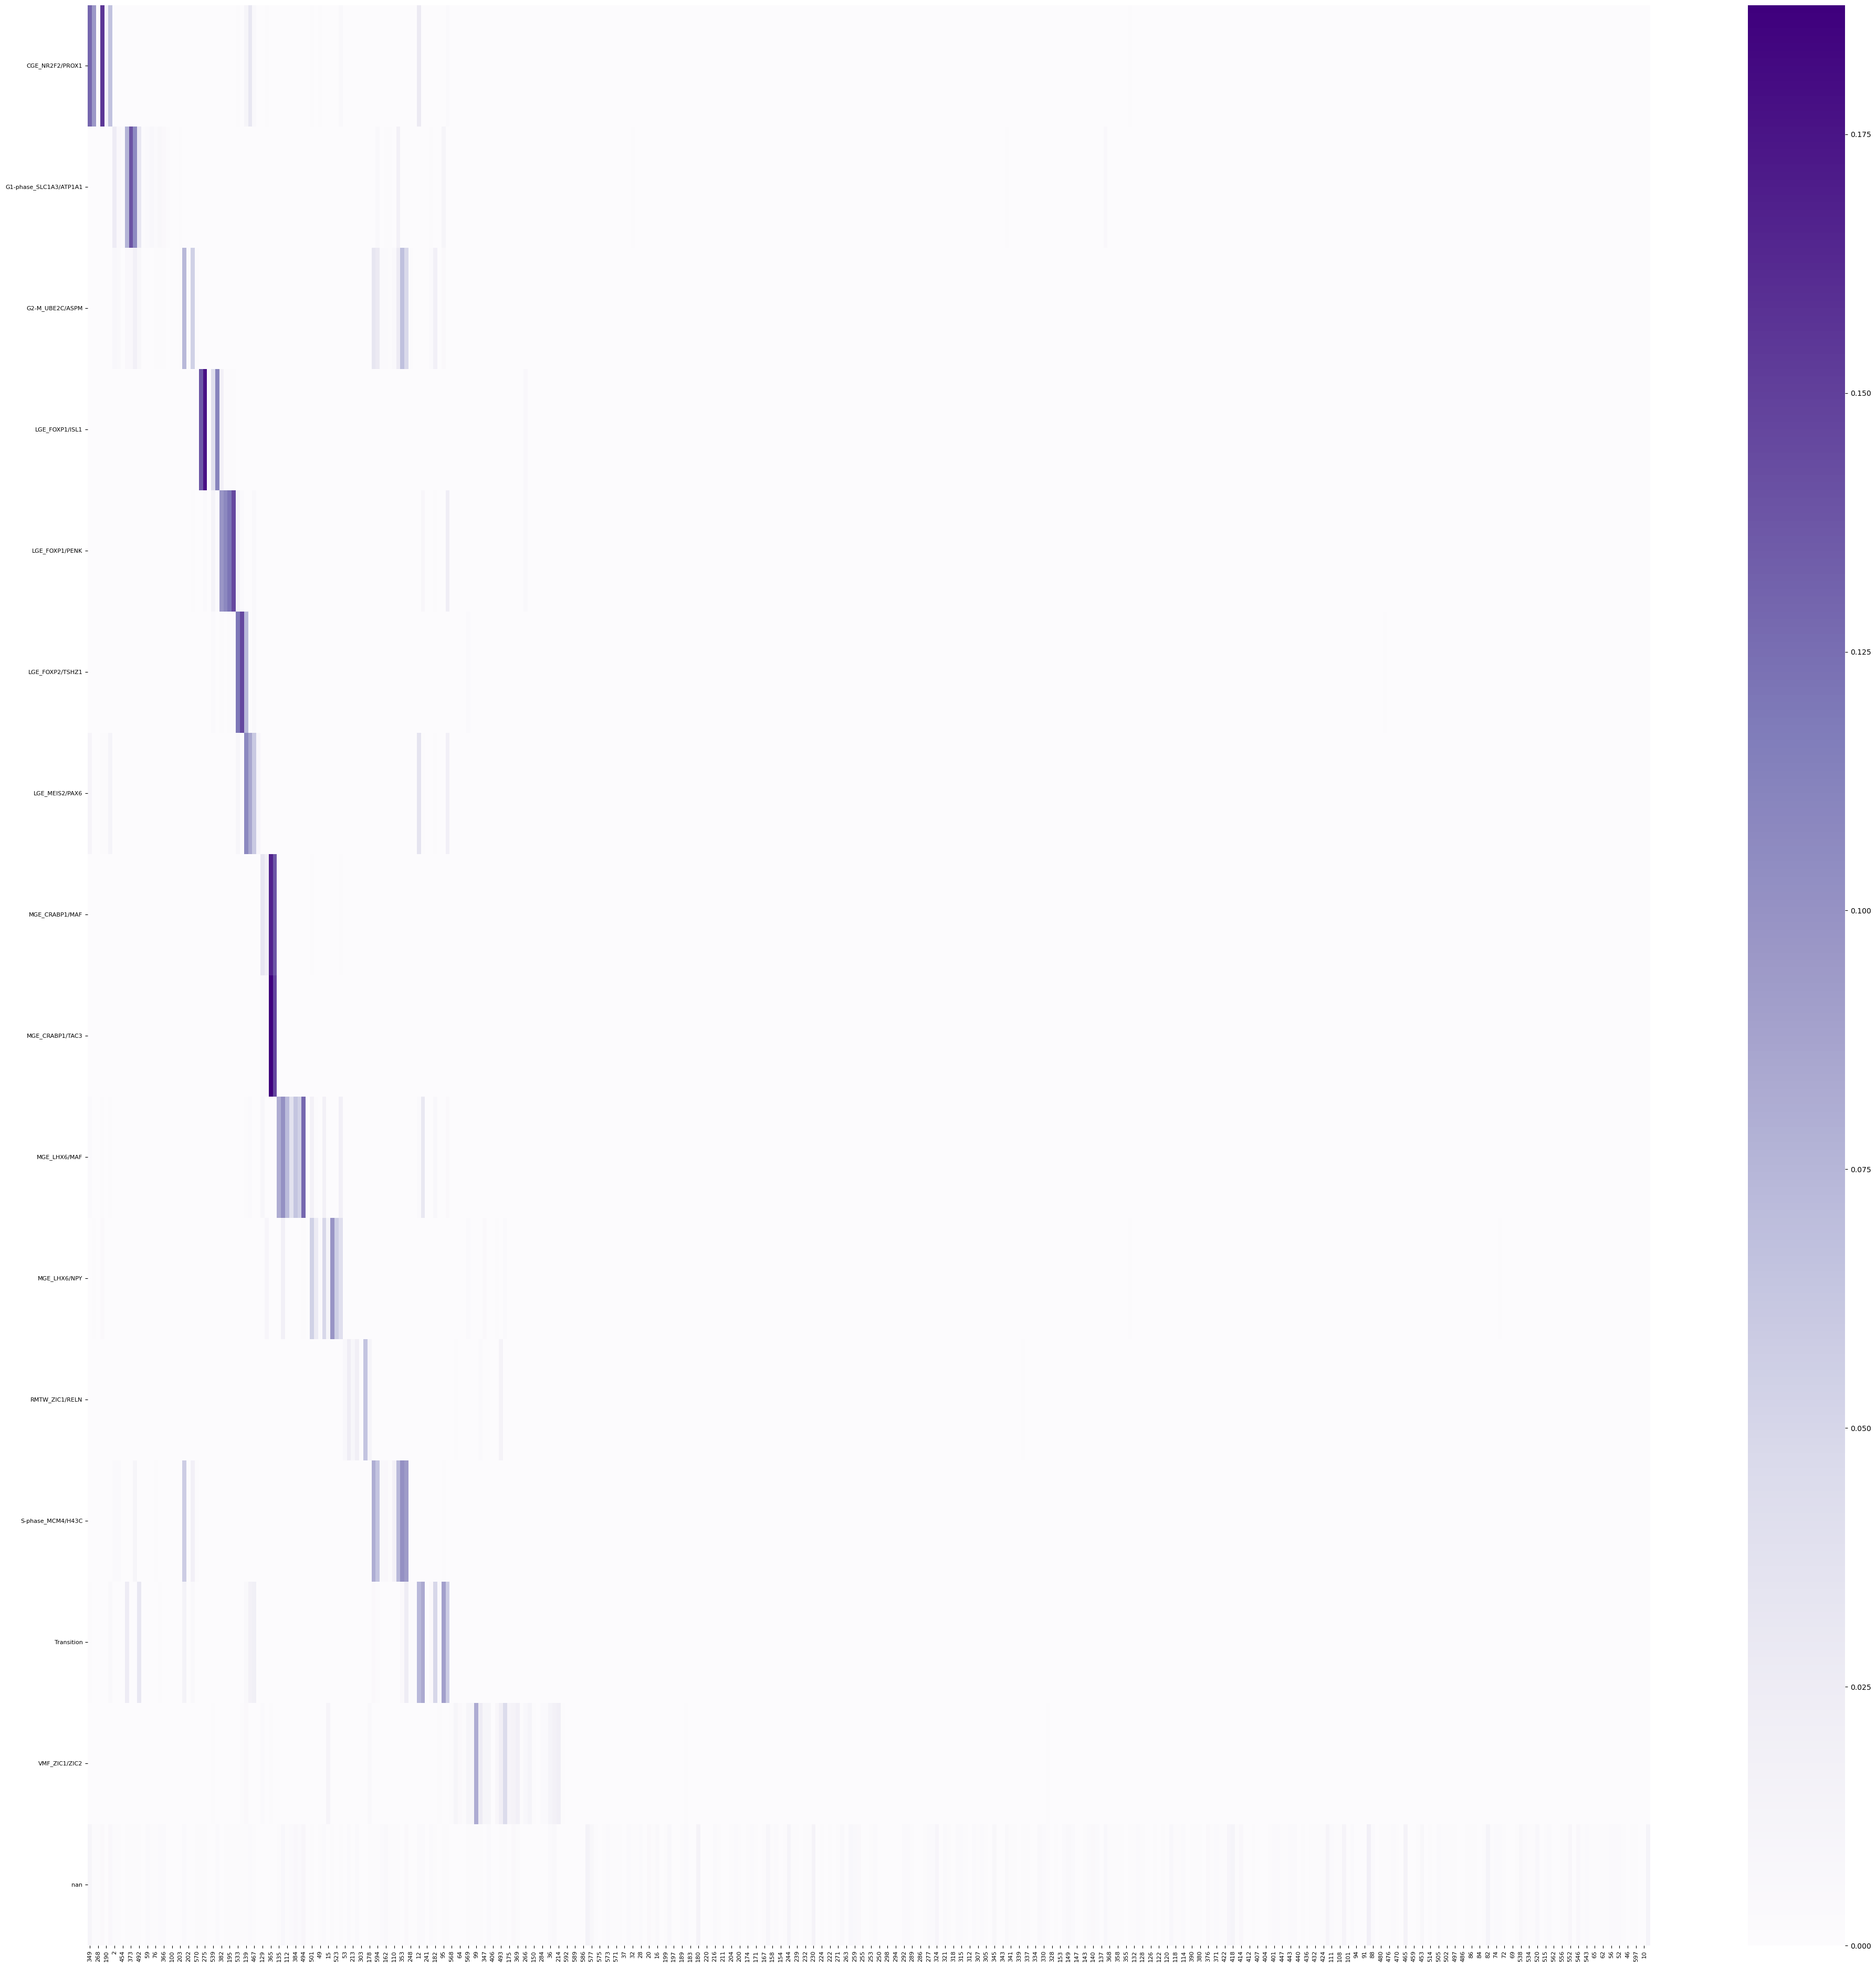

In [20]:
sc_analysis.create_heatmap(sc_analysis.get_cross_category_jaccard(adata.obs,'initial_class',leaf_key),cmap='Purples')

# Failure of MapMyCells

In [21]:
import json

# Path to your JSON file
file_path = '/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/data/taxtest/HvQvM/HvQvMall_cere_clean_nodoublets_ABC_MAPPING/hann_results.json'

# Open the file and load its content
with open(file_path, 'r') as file:
    data = json.load(file)

rows = []
for item in data['results']:
    row = {
        'cell_id': item['cell_id'],
        'class_label': item['class_label']['assignment'],
        'supertype_label': item['supertype_label']['assignment'],
        'subclass_label': item['subclass_label']['assignment'],
        'class_label2': item['class_label']['runner_up_assignment'],
        'supertype_label2': item['supertype_label']['runner_up_assignment'],
        'subclass_label2': item['subclass_label']['runner_up_assignment']
    }
    rows.append(row)

# Create a DataFrame
df = pd.DataFrame(rows)
df['cell_id']=df['cell_id'].str.replace('-[0-9]+$','',regex=True).str.replace('-[0-9]+$','',regex=True)
df.index=list(df['cell_id'])
df=df.loc[df['cell_id'].isin(adata.obs.index),:]
df=df.loc[~df.index.duplicated(),:]
adata.obs.loc[:,["class_label", "supertype_label", "subclass_label"]]=df.loc[:,["class_label", "supertype_label", "subclass_label"]]


In [22]:
import json

# Path to your JSON file
file_path = '/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/data/taxtest/HvQvM/HvQvMall_cere_clean_nodoublets_juvenile_MAPPING/hann_results.json'
#file_path = '/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/data/taxtest/HvQvM/HvQvMall_cere_clean_nodoublets_juvenile-TFonly_MAPPING//hann_results.json'

# Open the file and load its content
with open(file_path, 'r') as file:
    data = json.load(file)

rows = []
for item in data['results']:
    row = {
        'cell_id': item['cell_id'],
        'class_label': item['class_label']['assignment'],
        'supertype_label': item['supertype_label']['assignment'],
        'subclass_label': item['subclass_label']['assignment']
    }
    rows.append(row)

# Create a DataFrame
df = pd.DataFrame(rows)
df['cell_id']=df['cell_id'].str.replace('-[0-9]+$','',regex=True).str.replace('-[0-9]+$','',regex=True)
df.index=list(df['cell_id'])
df=df.loc[df['cell_id'].isin(adata.obs.index),:]
df=df.loc[~df.index.duplicated(),:]
df.columns=['juvenile_'+x for x in df.columns]
adata.obs.loc[df.index,["juvenile_class_label", "juvenile_supertype_label", "juvenile_subclass_label"]]=df.loc[:,["juvenile_class_label", "juvenile_supertype_label", "juvenile_subclass_label"]]

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


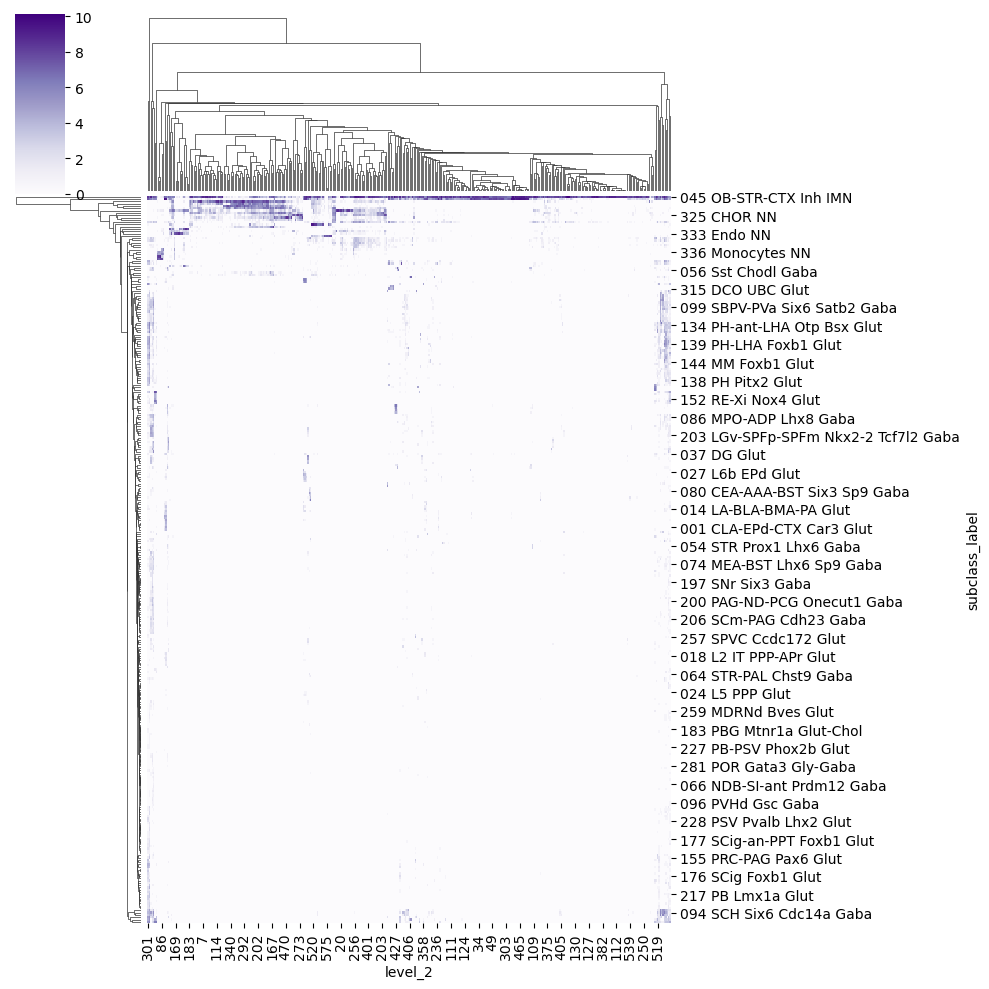

In [23]:
seaborn.clustermap(np.log(adata.obs.groupby('subclass_label')[leaf_key].value_counts().unstack()+1),cmap='Purples')

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


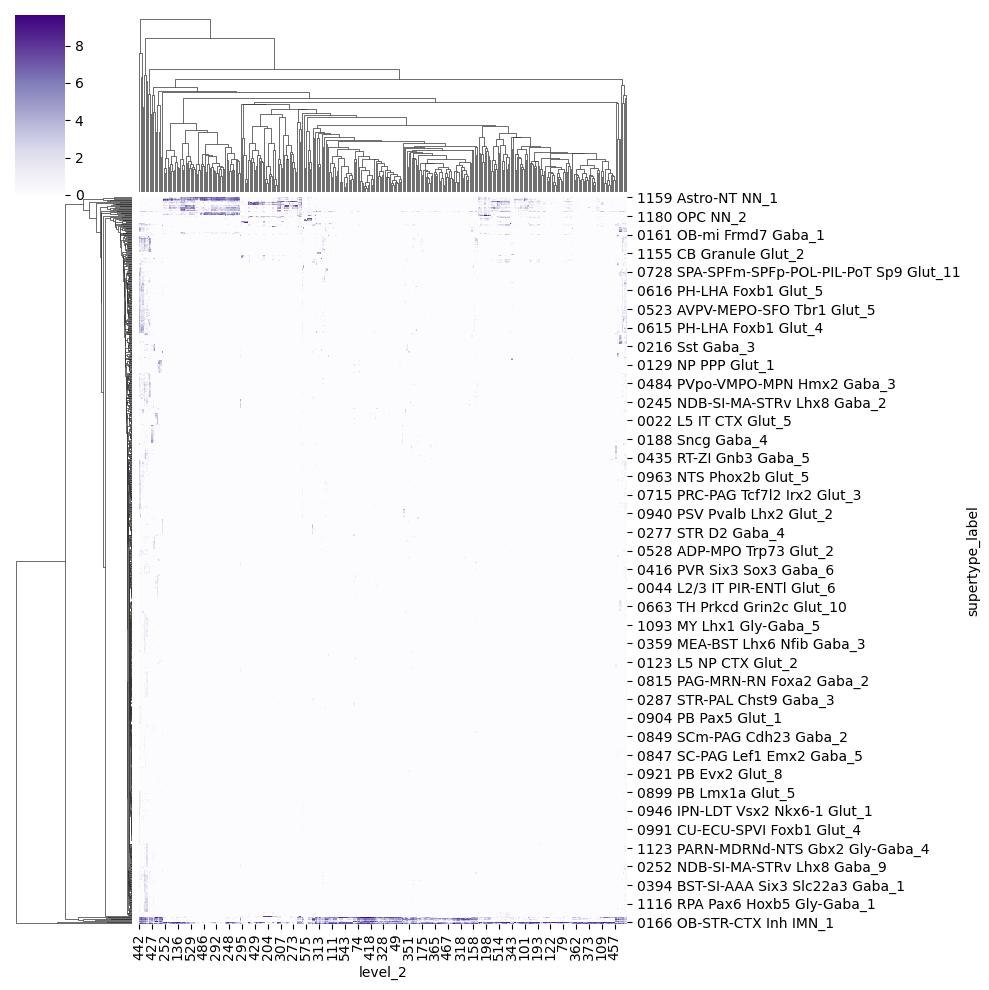

In [24]:
seaborn.clustermap(np.log(adata.obs.groupby('supertype_label')[leaf_key].value_counts().unstack()+1),cmap='Purples')

/scratch/fast/1725836/ipykernel_2805060/524432219.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  seaborn.clustermap(np.log(adata.obs.groupby('region')['subclass_label'].value_counts().unstack()+1))


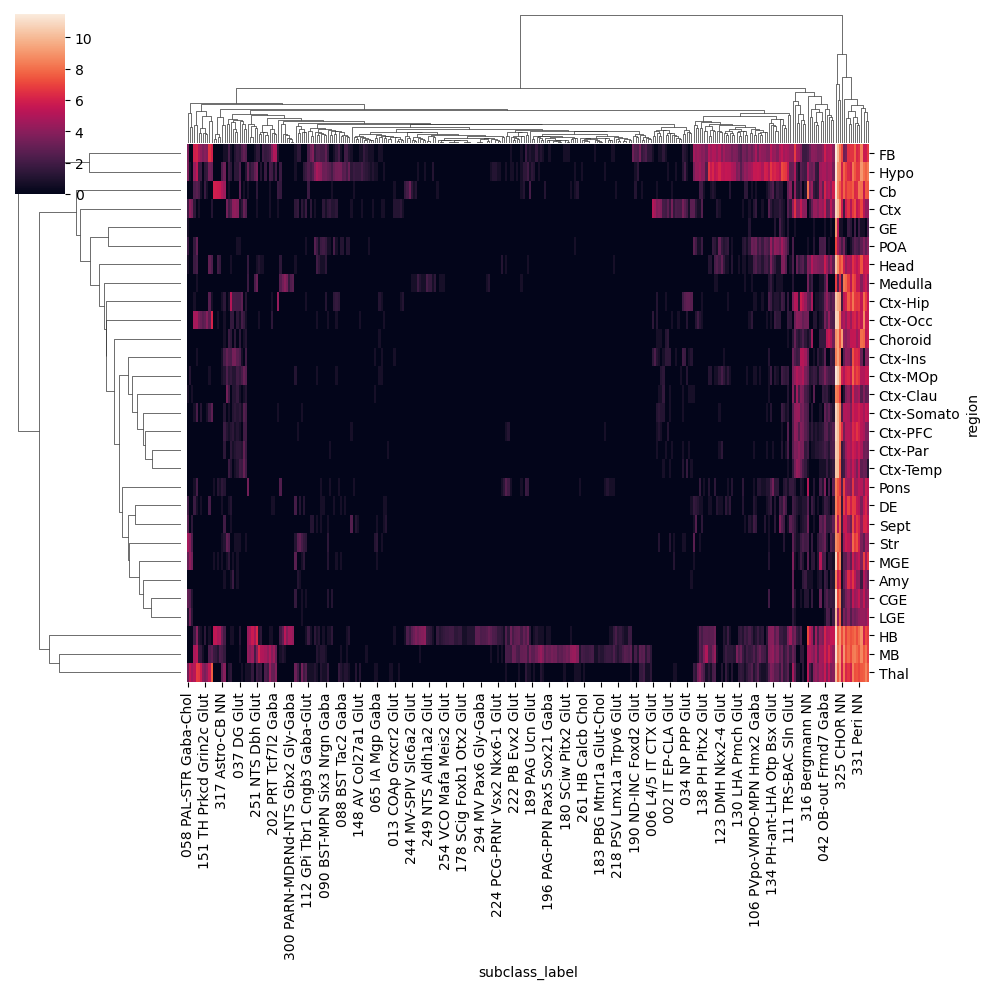

In [25]:
seaborn.clustermap(np.log(adata.obs.groupby('region')['subclass_label'].value_counts().unstack()+1))

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


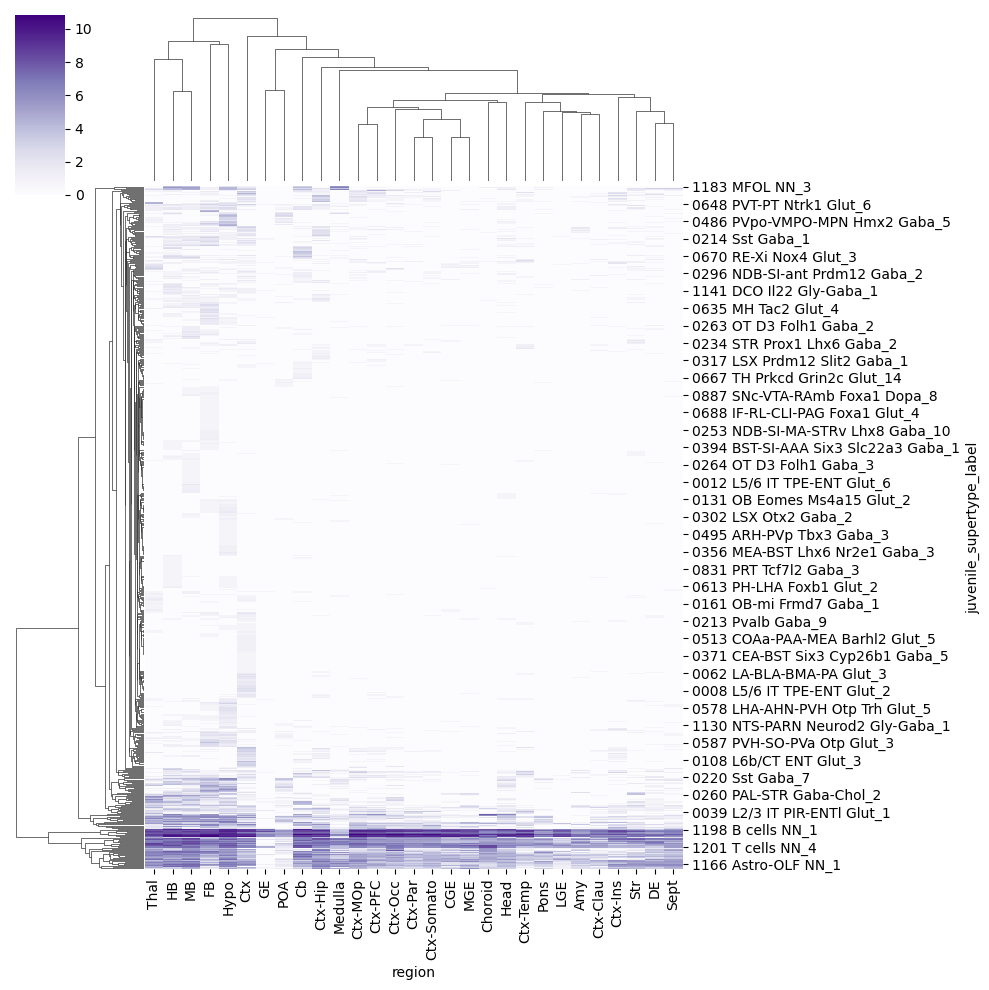

In [26]:
seaborn.clustermap(np.log(adata.obs.groupby('juvenile_supertype_label')['region'].value_counts().unstack()+1),cmap='Purples')

In [27]:
# sc.pl.embedding(
#     adata,
#     basis=MDE_KEY,
#     color=["class_label","subclass_label",'supertype_label'],
#     palette=sc.pl.palettes.godsnot_102,
# )



# sc.pl.embedding(
#     adata,
#     basis=MDE_KEY,
#     color=["linnarson_extended",'level_1',leaf_key,'initial_class','ic_extended'],
#     palette=sc.pl.palettes.godsnot_102,
#     legend_loc='on data'
# )


# Success of TF correlation

Used ABC (Yao 2023) subclasses in the dataset or with ABC mapped onto mouse juvenile (Linnarson)

In [28]:
log_real_means,real_mean_levels=antipode.model_functions.get_real_leaf_means(adata,discov_key,leaf_key,layer=layer_key)
real_means=pd.DataFrame(log_real_means.mean(0),columns=adata.var.index,index=real_mean_levels[leaf_key])
real_means=real_means.loc[real_mean_levels[leaf_key],:]

100%|██████████| 380/380 [04:17<00:00,  1.48it/s]


In [29]:
abc_subclass_means=pd.read_csv('/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/data/mouse_wb/AIT21.all.freeze.230815_subclassmeans.csv',index_col=0)

In [30]:
dev_mouse_means=pd.DataFrame(log_real_means[2],columns=adata.var.index,index=real_mean_levels[leaf_key])
dev_mouse_means=dev_mouse_means.loc[:,dev_mouse_means.columns.isin(abc_subclass_means.columns)]
dev_mouse_means = np.exp(dev_mouse_means-dev_mouse_means.max(0)) #scaled linear-space pseudobulk

In [31]:
abc_subclass_means=abc_subclass_means.loc[:,abc_subclass_means.columns.isin(dev_mouse_means.columns)]
abc_subclass_means=abc_subclass_means.loc[:,sorted(abc_subclass_means.columns)]

In [32]:
abc_subclass_means = np.exp(abc_subclass_means-abc_subclass_means.max(0)) #scaled linear-space pseudobulk

In [33]:
#Remove the OB granule cells because their immaturity is a magnet for all dev cells
abc_subclass_means=abc_subclass_means.loc[~abc_subclass_means.index.str.contains('OB-STR'),:]

In [34]:
# gl_path='/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/data/taxtest/gene_lists/'
# tf_genes=pd.read_csv(os.path.join(gl_path,'TFs_lambert_pmid29425488_1.01.txt'),sep='\t')
# include_genes=tf_genes['hgnc_symbol']

In [35]:
tf_genes=pd.read_csv('/home/matthew.schmitz/Matthew/utils/zizhens_tf_code.txt',sep='\t')
include_genes=tf_genes['gene'].str.upper()

In [36]:
corrs=sc_analysis.corr2_coeff(dev_mouse_means.loc[:,dev_mouse_means.columns.isin(include_genes)],abc_subclass_means.loc[:,abc_subclass_means.columns.isin(include_genes)])

corrs=np.nan_to_num(corrs,0.)
corrs=pd.DataFrame(corrs,index=dev_mouse_means.index,columns=abc_subclass_means.index)

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


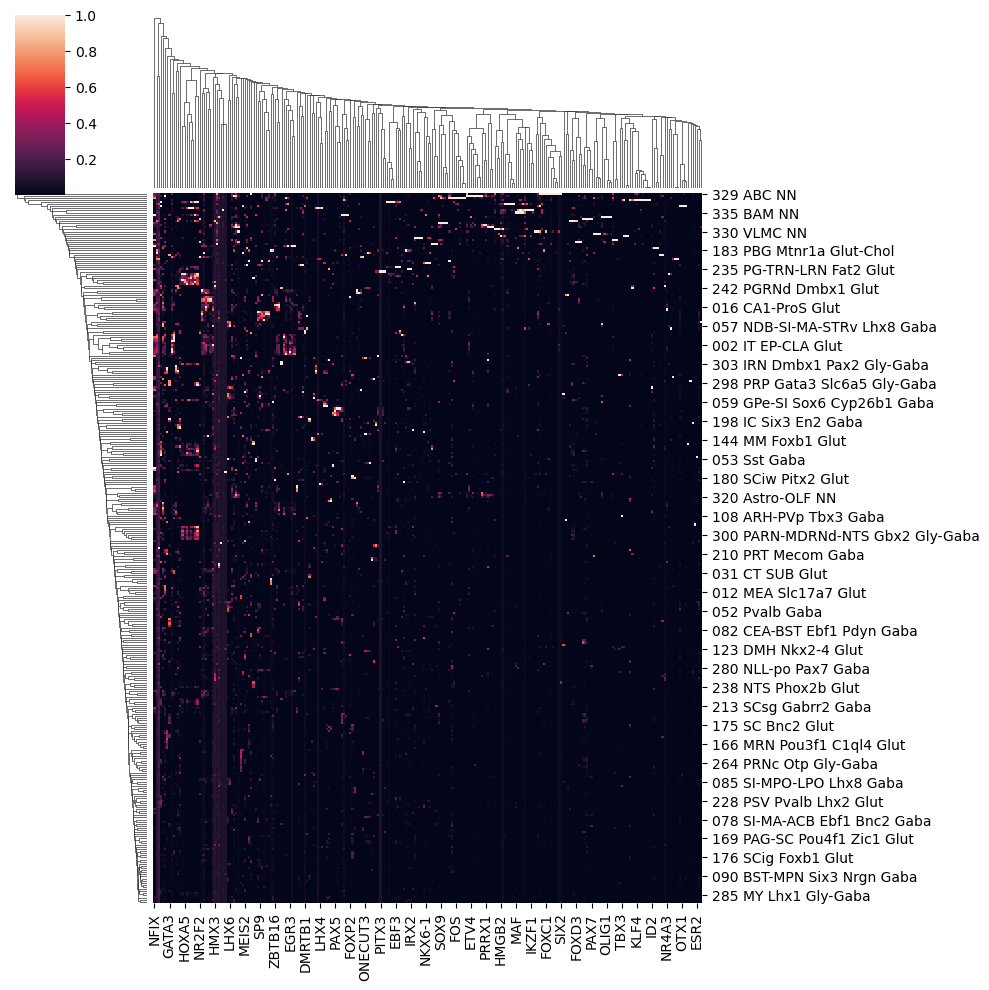

In [37]:
seaborn.clustermap(abc_subclass_means.loc[:,abc_subclass_means.columns.isin(include_genes)],col_cluster=True)
plt.savefig(os.path.join(sc.settings.figdir,'adult_mouse_adult_mouse_tf_means.svg'))

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


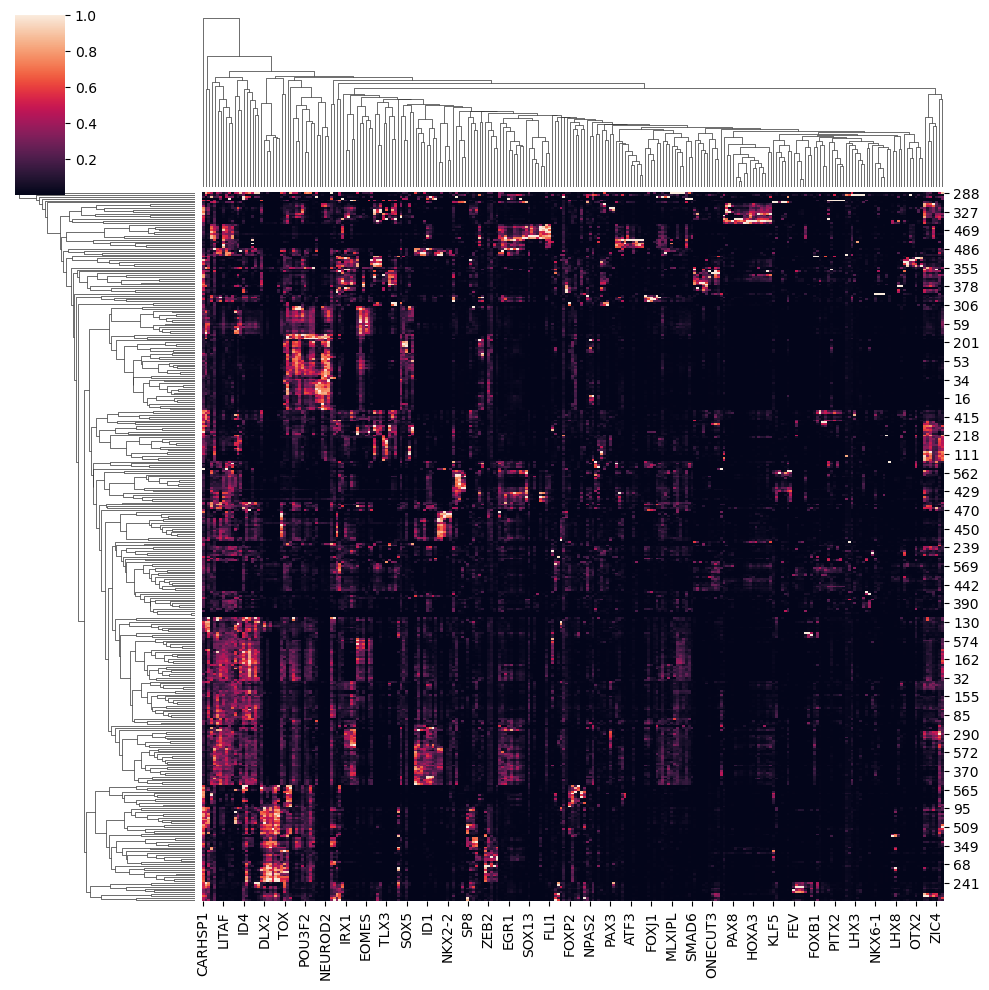

In [38]:
seaborn.clustermap(dev_mouse_means.loc[:,dev_mouse_means.columns.isin(include_genes)],col_cluster=True)
plt.savefig(os.path.join(sc.settings.figdir,'dev_mouse_adult_mouse_tf_means.svg'))

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


[Text(1, 0.5, '303'),
 Text(1, 1.5, '422'),
 Text(1, 2.5, '140'),
 Text(1, 3.5, '543'),
 Text(1, 4.5, '165'),
 Text(1, 5.5, '173'),
 Text(1, 6.5, '87'),
 Text(1, 7.5, '88'),
 Text(1, 8.5, '59'),
 Text(1, 9.5, '124'),
 Text(1, 10.5, '269'),
 Text(1, 11.5, '536'),
 Text(1, 12.5, '573'),
 Text(1, 13.5, '253'),
 Text(1, 14.5, '333'),
 Text(1, 15.5, '53'),
 Text(1, 16.5, '63'),
 Text(1, 17.5, '463'),
 Text(1, 18.5, '16'),
 Text(1, 19.5, '418'),
 Text(1, 20.5, '230'),
 Text(1, 21.5, '345'),
 Text(1, 22.5, '117'),
 Text(1, 23.5, '576'),
 Text(1, 24.5, '207'),
 Text(1, 25.5, '141'),
 Text(1, 26.5, '421'),
 Text(1, 27.5, '149'),
 Text(1, 28.5, '577'),
 Text(1, 29.5, '305'),
 Text(1, 30.5, '61'),
 Text(1, 31.5, '128'),
 Text(1, 32.5, '201'),
 Text(1, 33.5, '424'),
 Text(1, 34.5, '315'),
 Text(1, 35.5, '161'),
 Text(1, 36.5, '268'),
 Text(1, 37.5, '337'),
 Text(1, 38.5, '581'),
 Text(1, 39.5, '423'),
 Text(1, 40.5, '411'),
 Text(1, 41.5, '324'),
 Text(1, 42.5, '82'),
 Text(1, 43.5, '244'),
 Text(

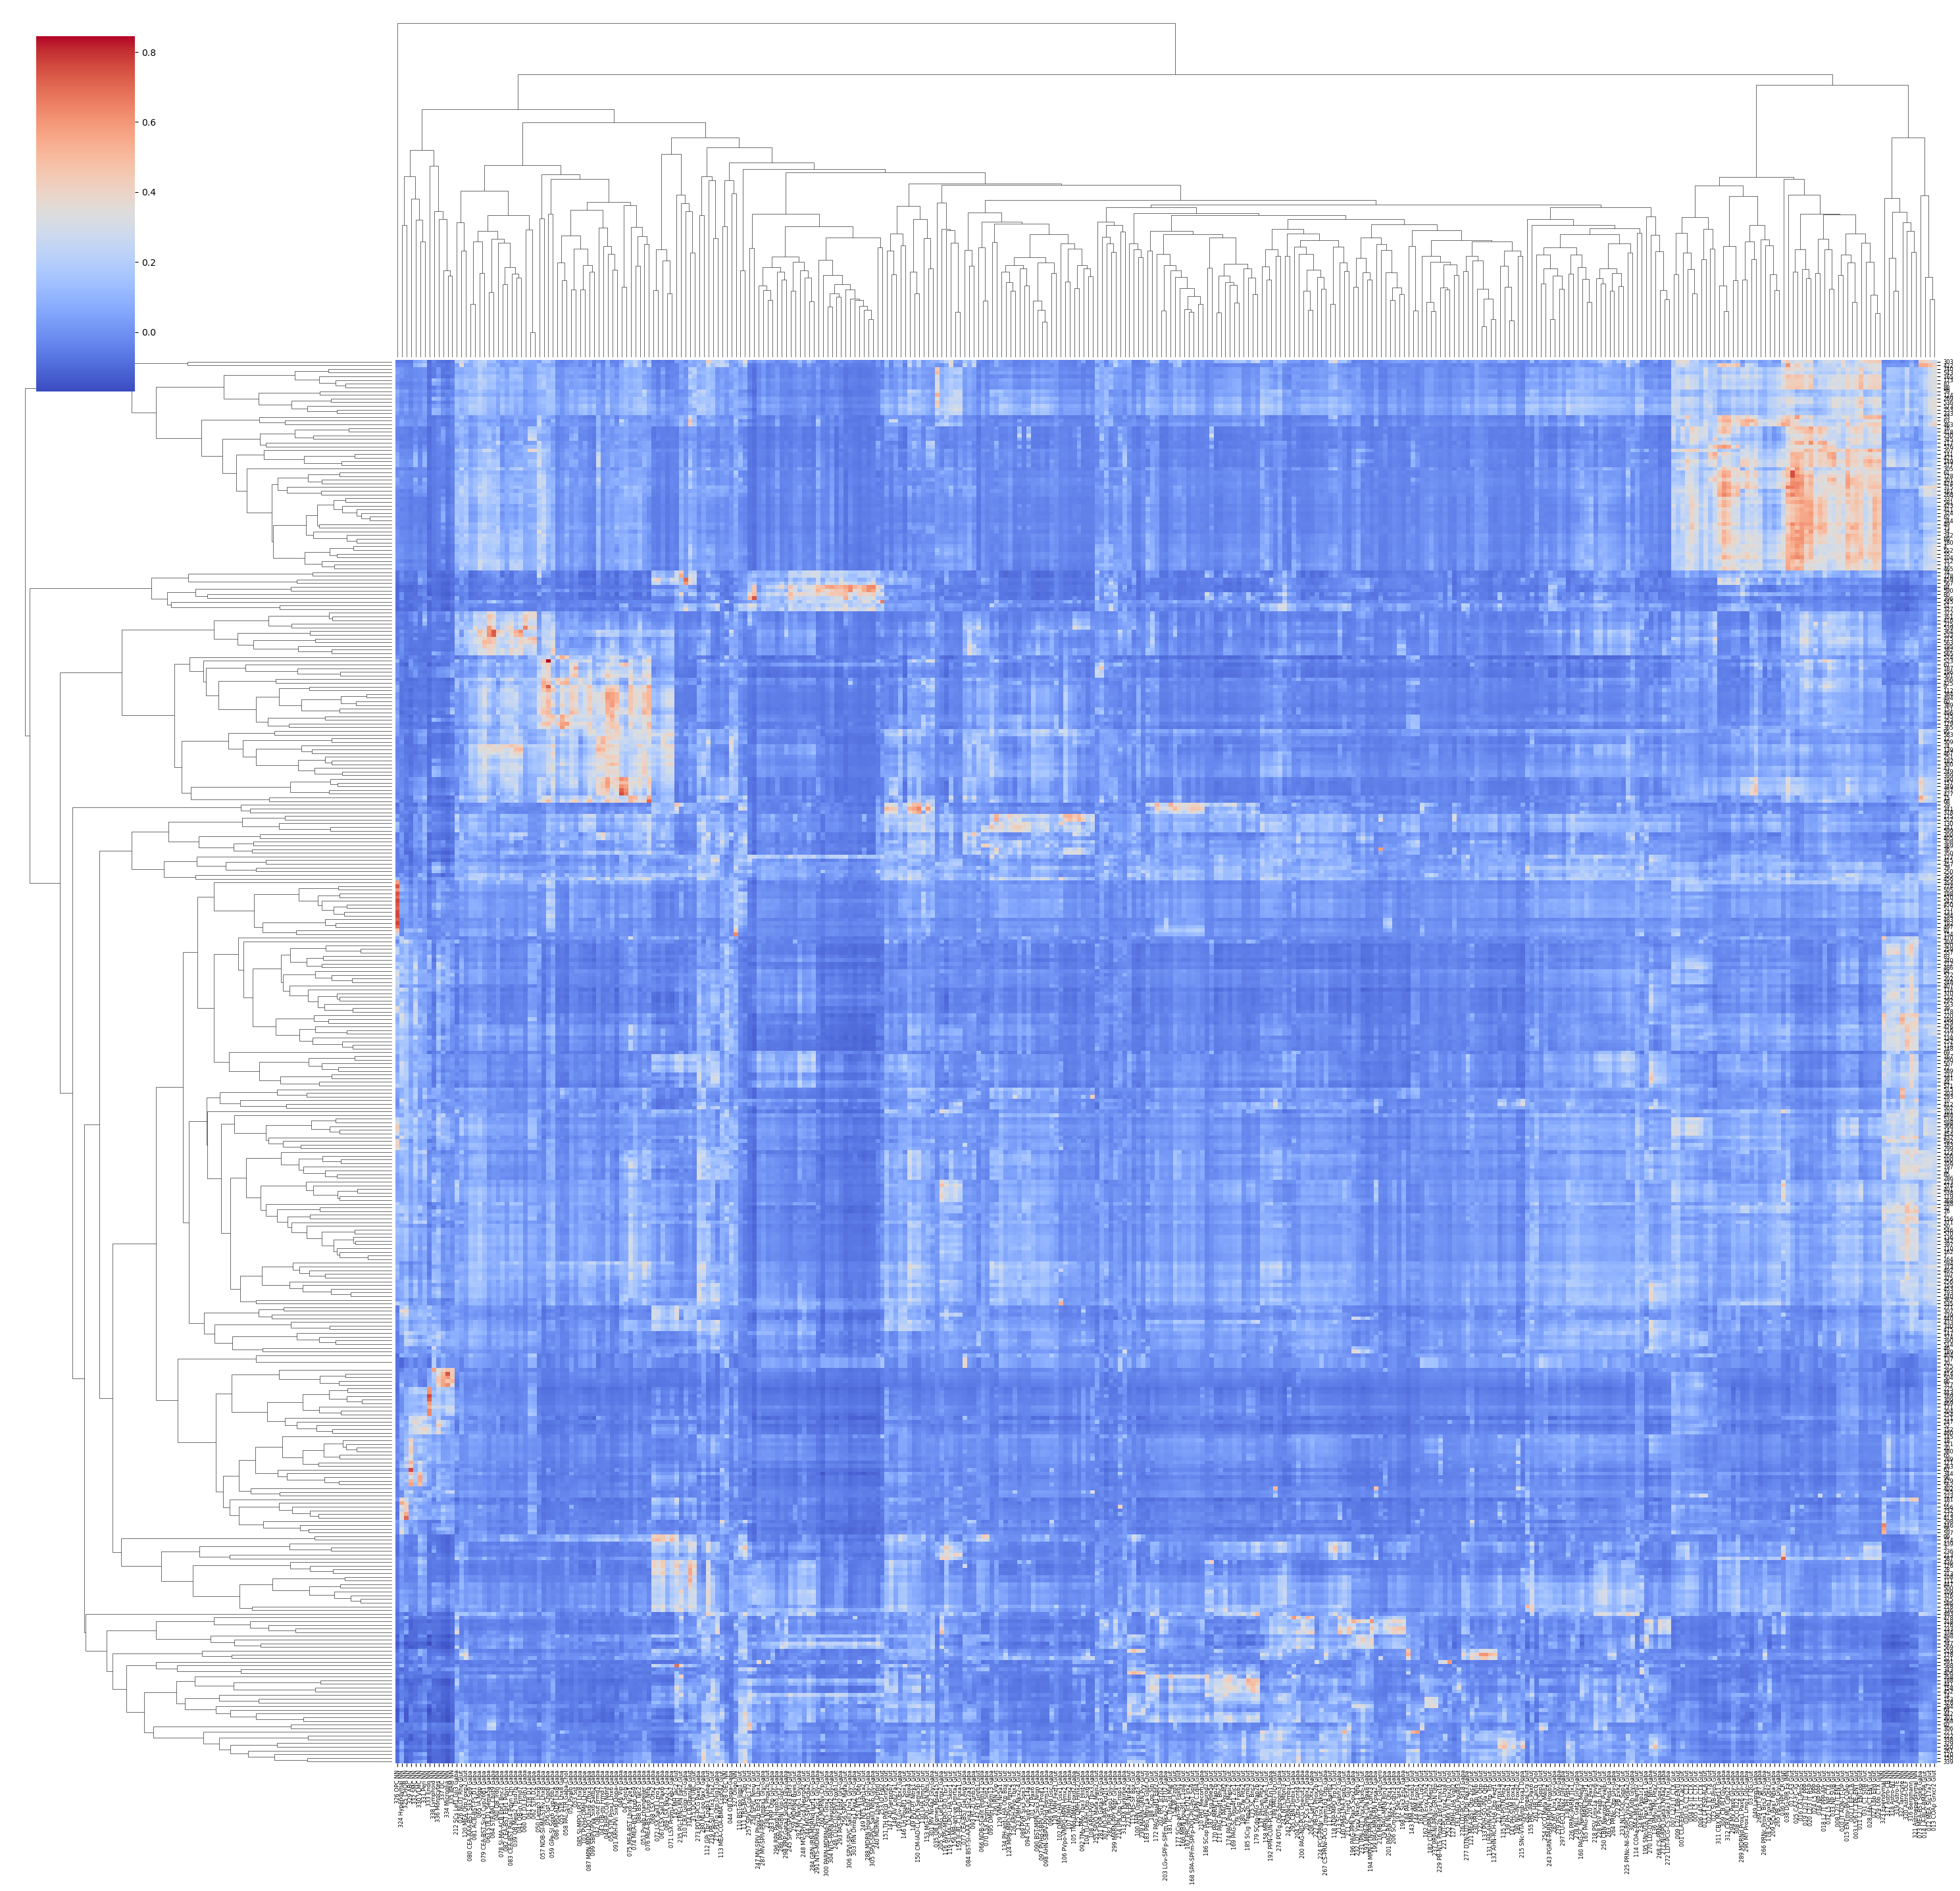

In [41]:
g = seaborn.clustermap(corrs,cmap='coolwarm',figsize=(30,30),xticklabels=True,yticklabels=True,row_cluster=True,col_cluster=True)
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xmajorticklabels(), fontsize = 6)
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_ymajorticklabels(), fontsize = 6)
# plt.savefig(os.path.join(sc.settings.figdir,'dev_mouse_adult_mouse_corrs.svg'))

In [42]:
marker_corr_dict=corrs.idxmax(1).to_dict()

In [43]:
adata.obs['abc_subclass_markercor']=adata.obs[leaf_key].replace(marker_corr_dict)

/scratch/fast/1725836/ipykernel_2805060/966325606.py:1: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  adata.obs['abc_subclass_markercor']=adata.obs[leaf_key].replace(marker_corr_dict)


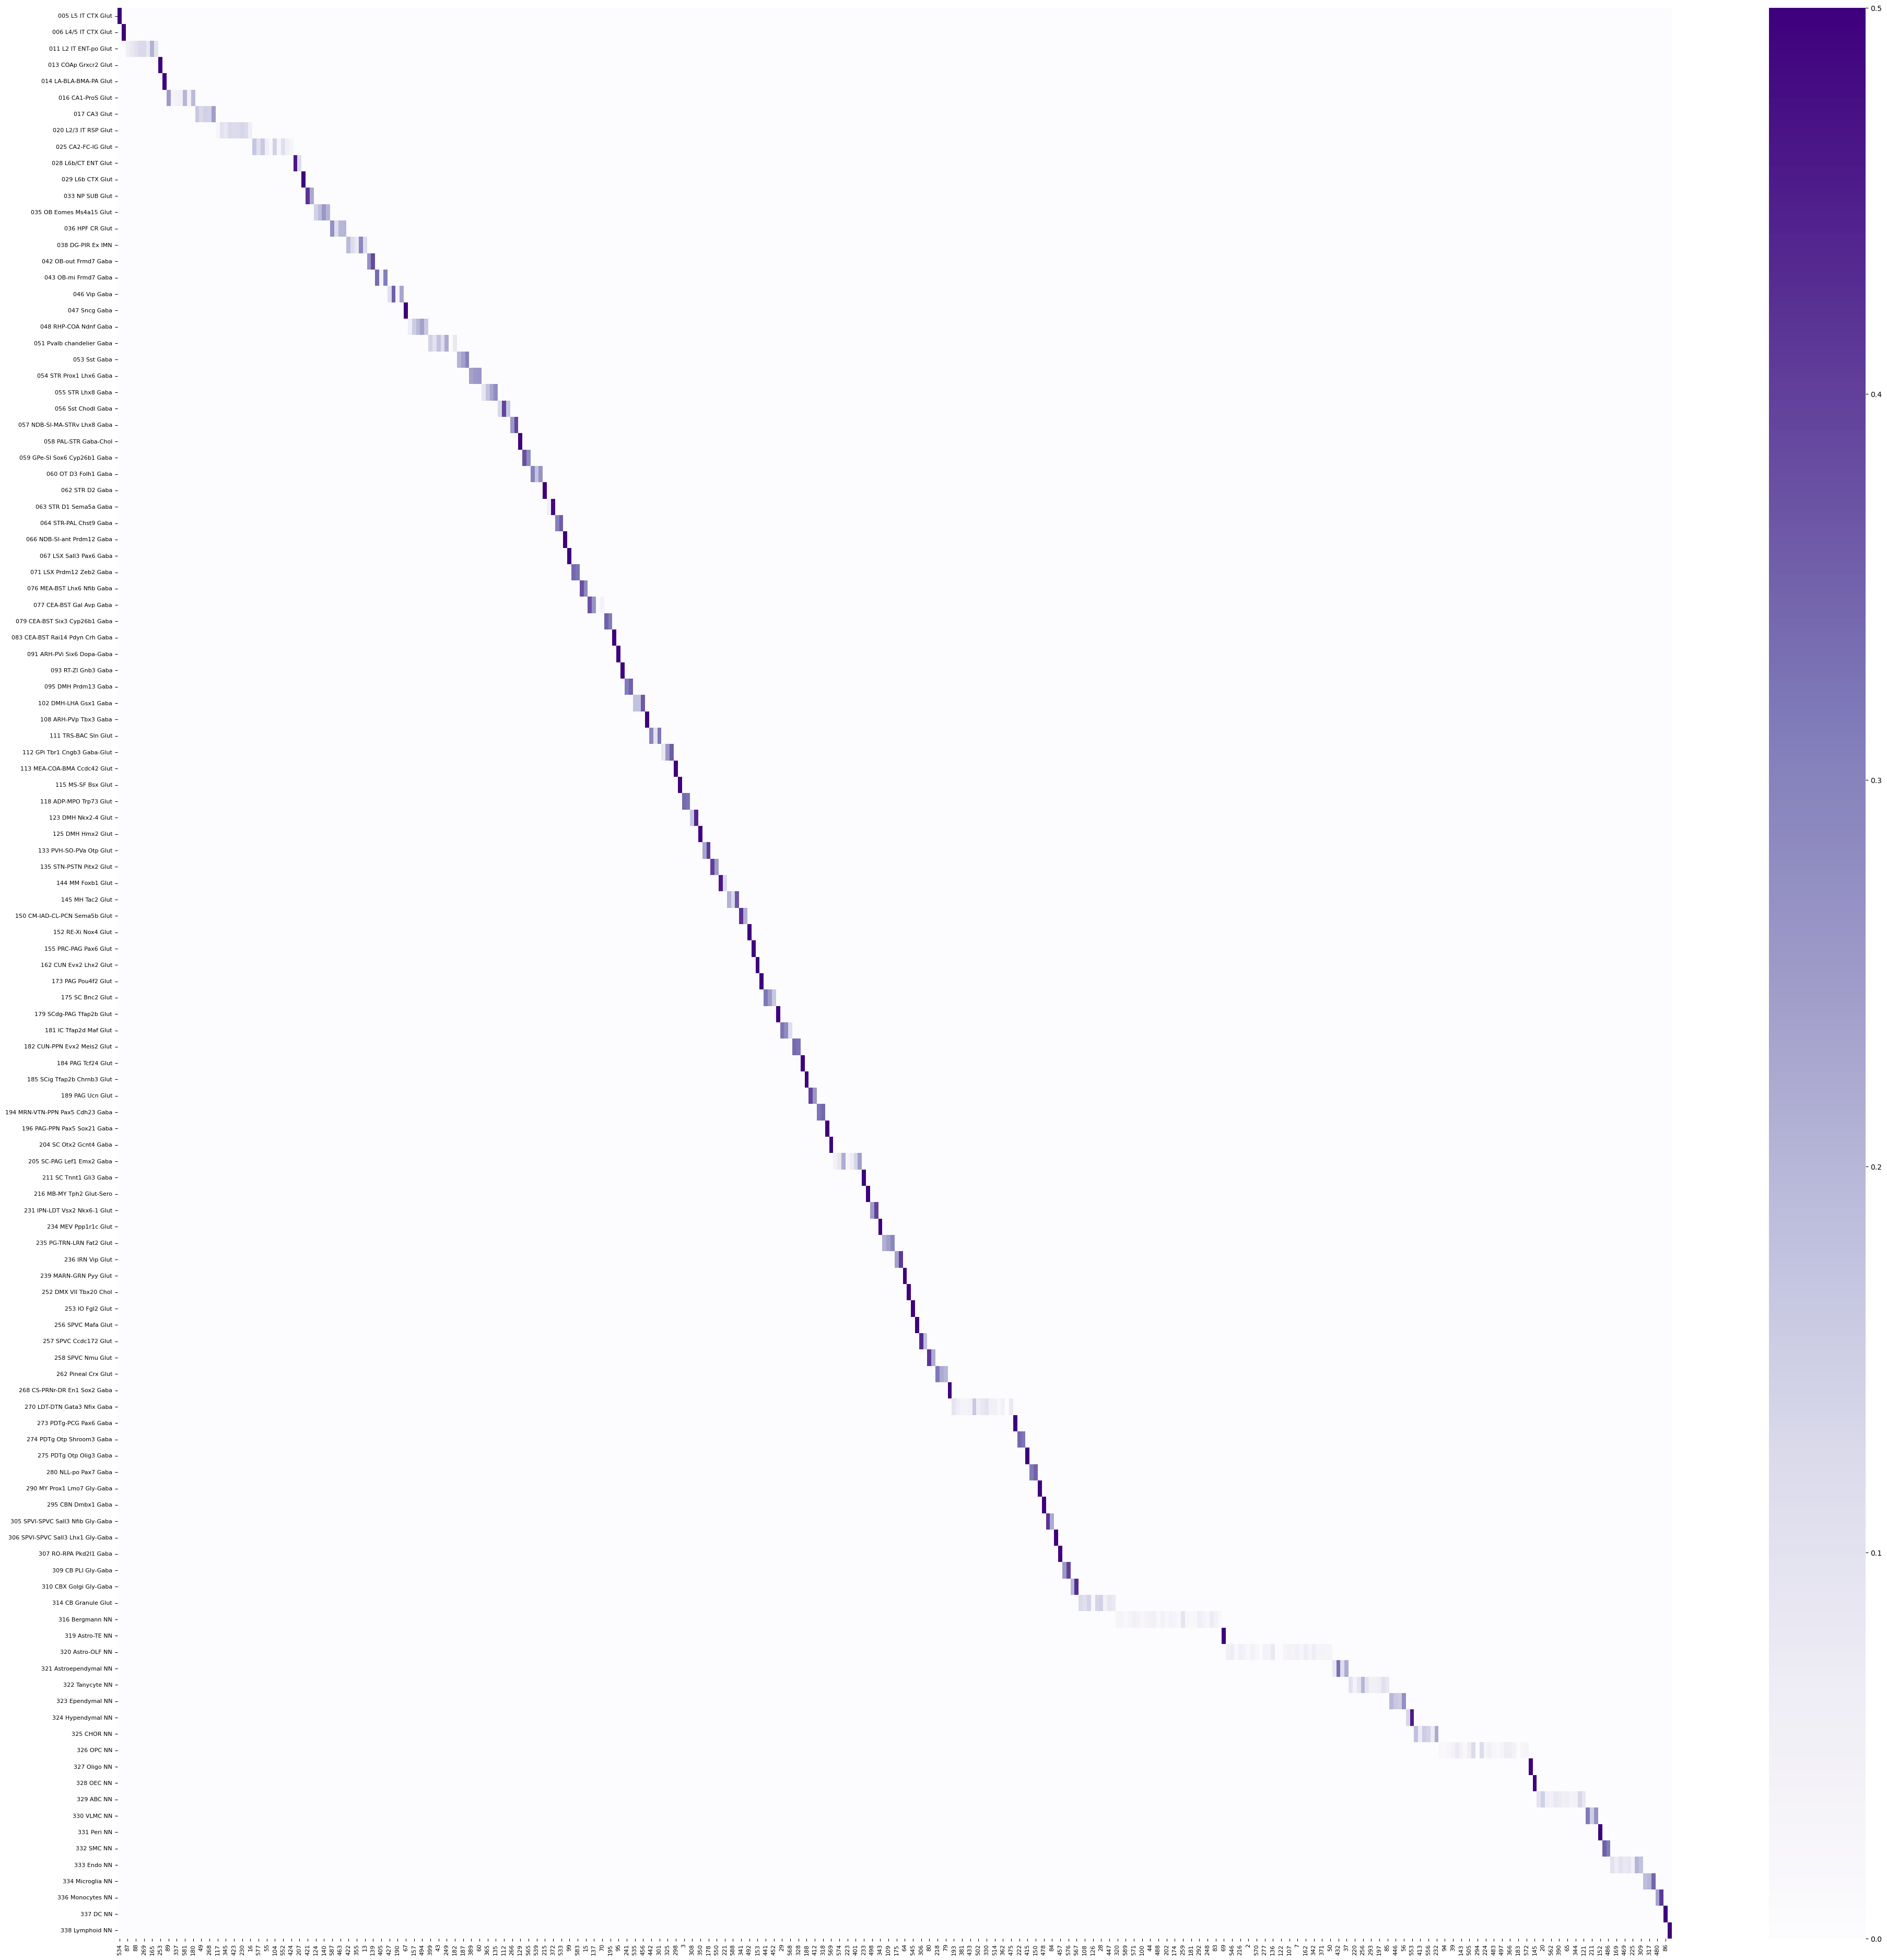

In [44]:
adata.obs['abc_subclass_markercor'] = adata.obs['abc_subclass_markercor'].cat.reorder_categories(sorted(adata.obs['abc_subclass_markercor'].cat.categories))
sc_analysis.create_heatmap(sc_analysis.get_cross_category_jaccard(adata.obs,'abc_subclass_markercor',leaf_key),cmap='Purples')
plt.savefig(os.path.join(sc.settings.figdir,'dev_abc_jaccards.svg'))

In [45]:
dev_mouse_means.to_csv('/home/matthew.schmitz/Matthew/data/taxtest/annotations/dev_mouse_means.csv')
abc_subclass_means.to_csv('/home/matthew.schmitz/Matthew/data/taxtest/annotations/abc_mouse_means.csv')

# ABC -> Juvenile Mouse -> Development Mouse

In [46]:
juvdata=sc.read_h5ad(os.path.expanduser('/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/data/taxtest/extra/KDCbVelocityMouseWbAdultPresupervisionHumanOrthos.h5ad'))

In [47]:
# juv_aggr_means=antipode.model_functions.group_aggr_anndata(juvdata,['subclass_label'])

juv_aggr_means=antipode.model_functions.group_aggr_anndata(juvdata,['subclass_label'],layer='spliced',normalize=True)
juv_aggr_sums=antipode.model_functions.group_aggr_anndata(juvdata,['subclass_label'],layer='spliced',normalize=False,agg_func=np.sum)
juv_log_real_means=antipode.model_functions.safe_log_transform(juv_aggr_means[0],juv_aggr_sums[0].sum(-1)[...,np.newaxis])

100%|██████████| 327/327 [00:47<00:00,  6.94it/s]


In [48]:
juv_mouse_means=pd.DataFrame(juv_log_real_means,columns=juvdata.var.index,index=juv_aggr_means[1]['subclass_label'])
dev_mouse_means=pd.DataFrame(log_real_means[2],columns=adata.var.index,index=real_mean_levels[leaf_key])
dev_mouse_means=dev_mouse_means.loc[:,dev_mouse_means.columns.isin(abc_subclass_means.columns)]

In [49]:
juv_mouse_means = np.exp(juv_mouse_means-juv_mouse_means.max(0)) #scaled linear-space pseudobulk
dev_mouse_means = np.exp(dev_mouse_means-dev_mouse_means.max(0)) #scaled linear-space pseudobulk

In [50]:
juv_mouse_means=juv_mouse_means.loc[:,juv_mouse_means.columns.isin(dev_mouse_means.columns)]
dev_mouse_means=dev_mouse_means.loc[:,dev_mouse_means.columns.isin(juv_mouse_means.columns)]
juv_mouse_means=juv_mouse_means.loc[:,dev_mouse_means.columns]

In [51]:
tf_genes=pd.read_csv('/home/matthew.schmitz/Matthew/utils/zizhens_tf_code.txt',sep='\t')
include_genes=tf_genes['gene'].str.upper()

In [52]:
corrs=sc_analysis.corr2_coeff(dev_mouse_means.loc[:,dev_mouse_means.columns.isin(include_genes)],juv_mouse_means.loc[:,juv_mouse_means.columns.isin(include_genes)])
corrs=np.nan_to_num(corrs,0.)
corrs=pd.DataFrame(corrs,index=dev_mouse_means.index,columns=juv_mouse_means.index)

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


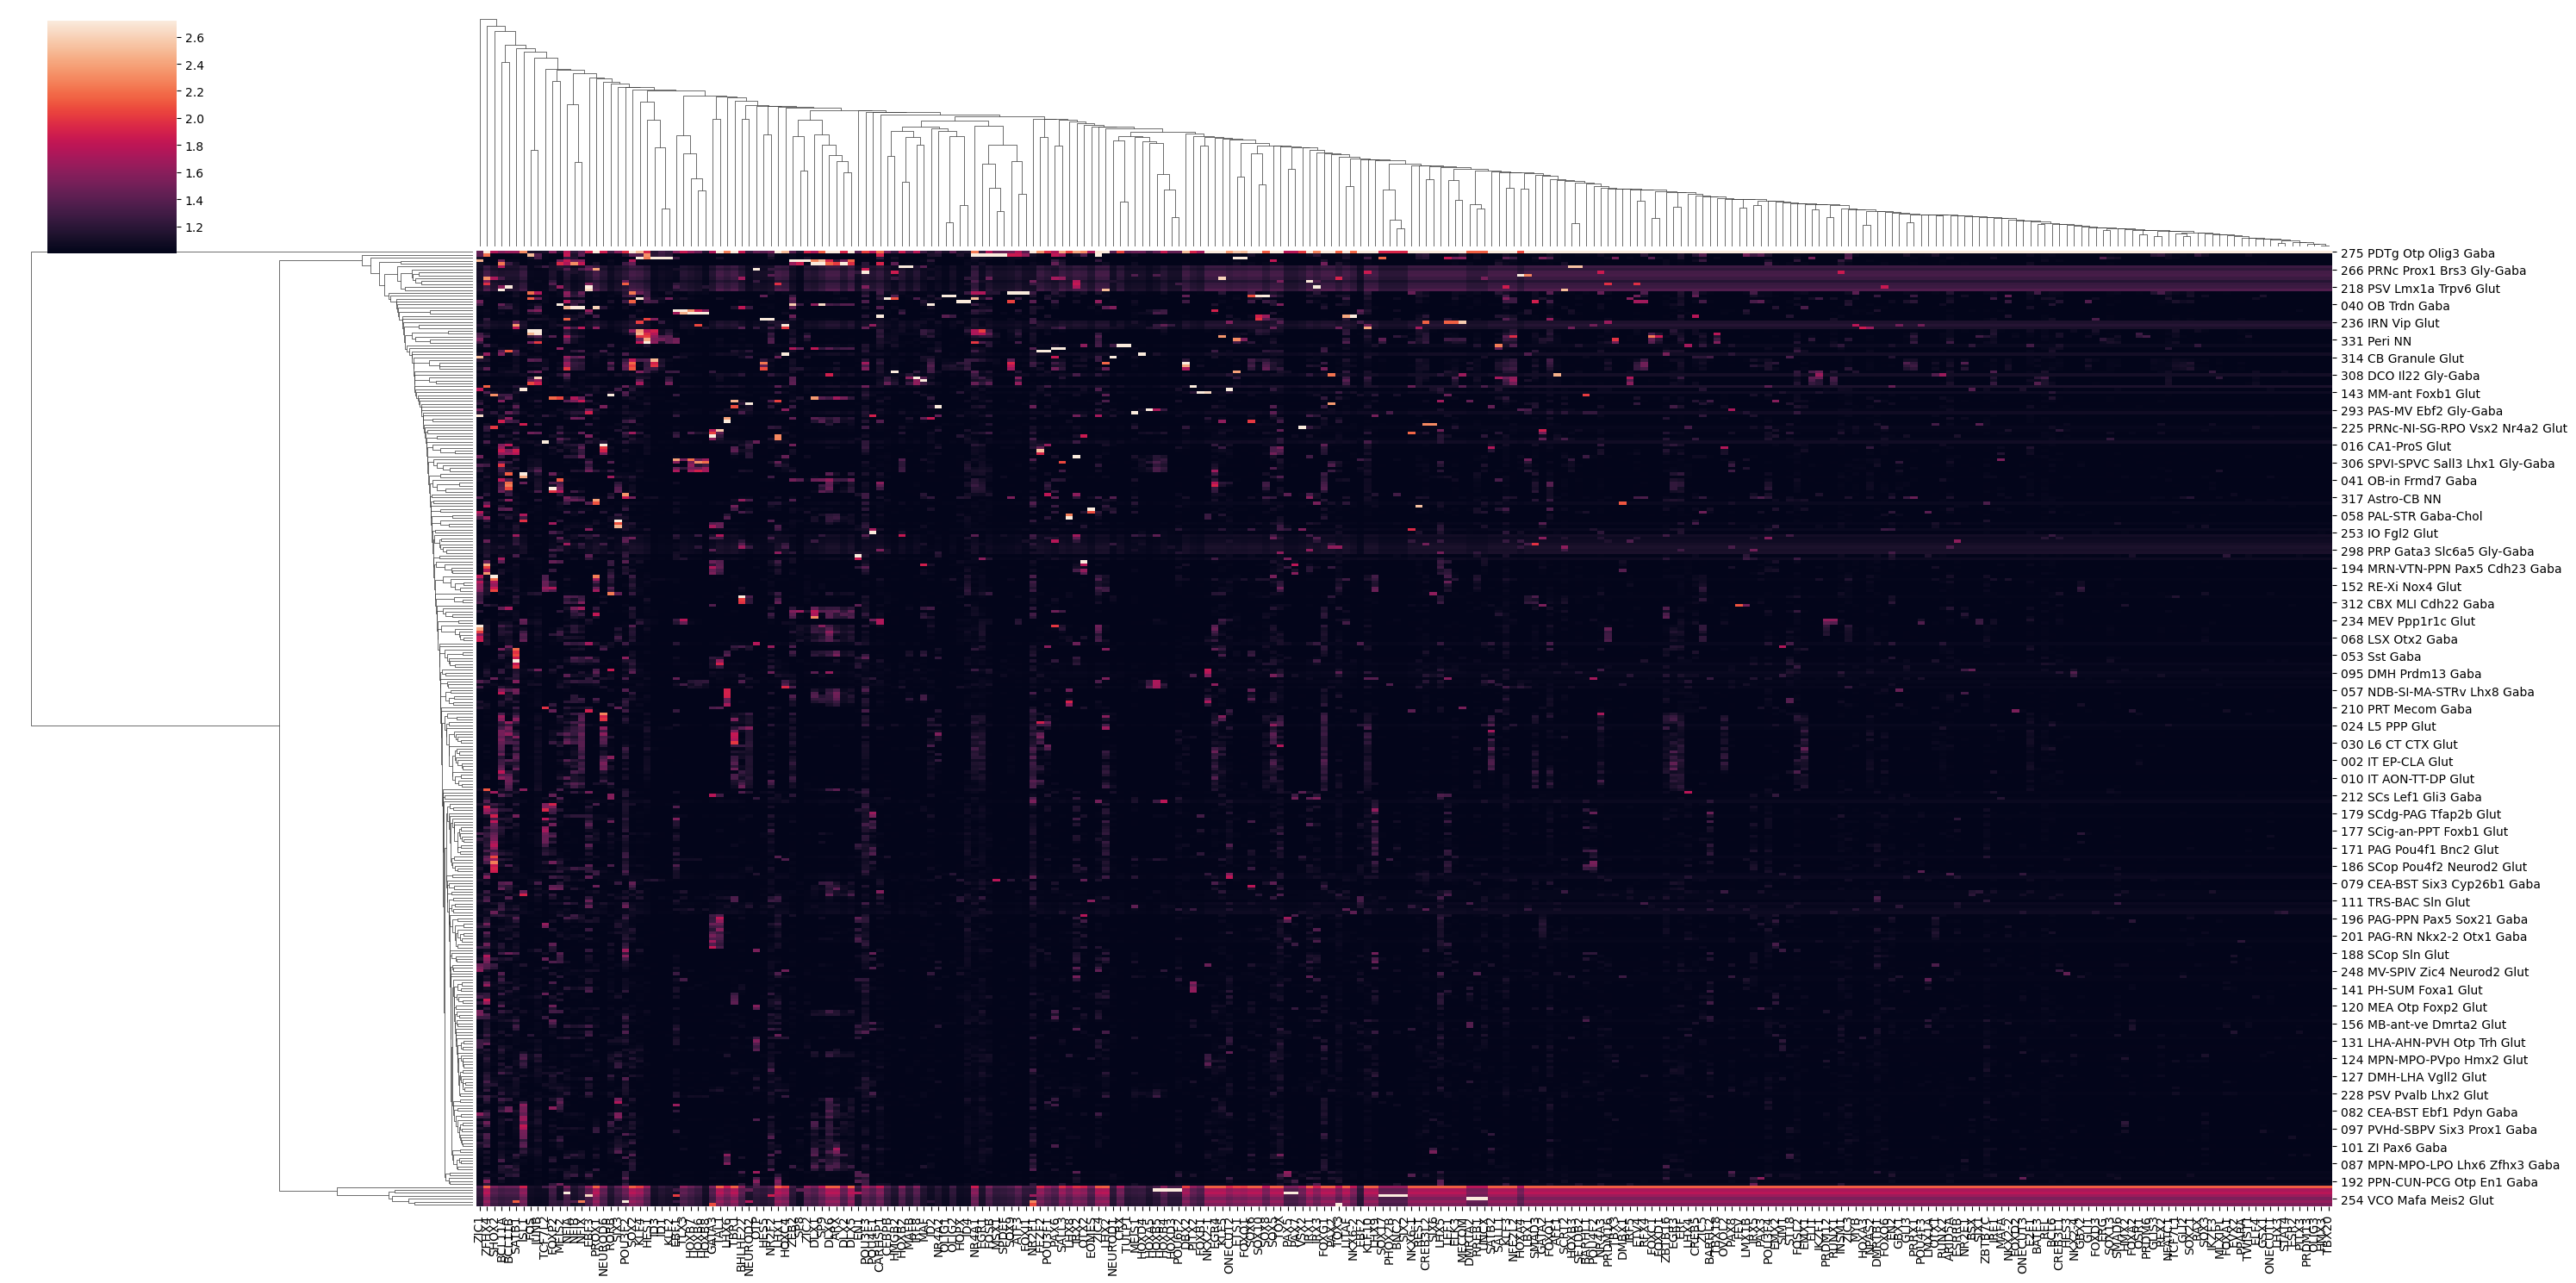

In [53]:
seaborn.clustermap(np.exp(juv_mouse_means.loc[:,juv_mouse_means.columns.isin(include_genes)]),col_cluster=True,xticklabels=True, figsize=(30,15))

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


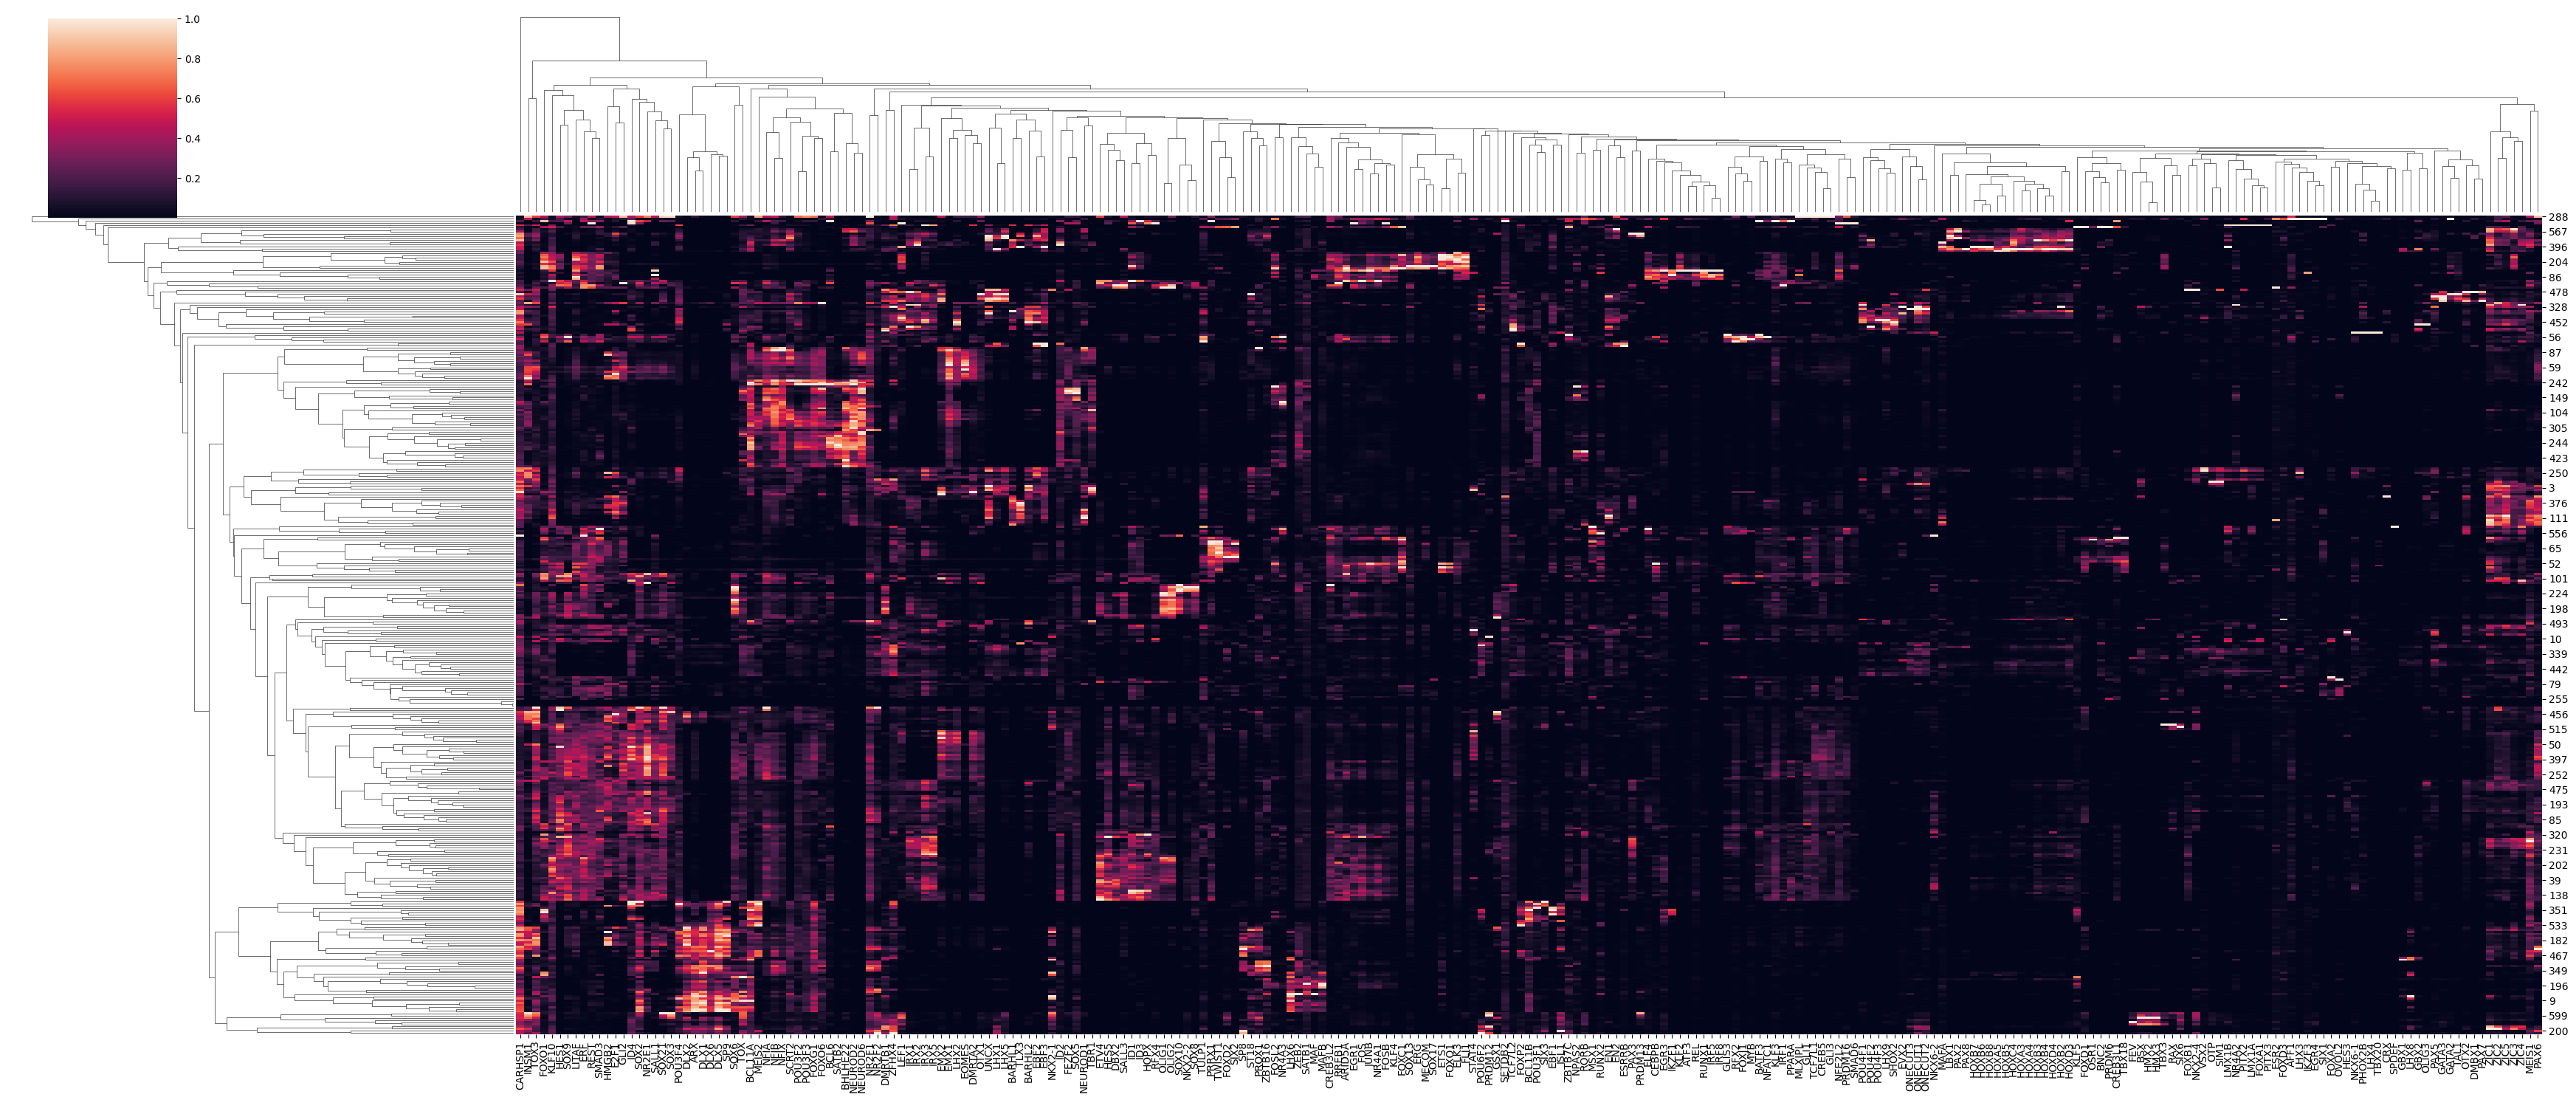

In [54]:
# plt.figure(figsize=(25,15))
seaborn.clustermap(dev_mouse_means.loc[:,dev_mouse_means.columns.isin(include_genes)],col_cluster=True,xticklabels=True, figsize=(35,15))
plt.savefig(os.path.join(sc.settings.figdir,'mouse_tf_heatmap.pdf'))

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


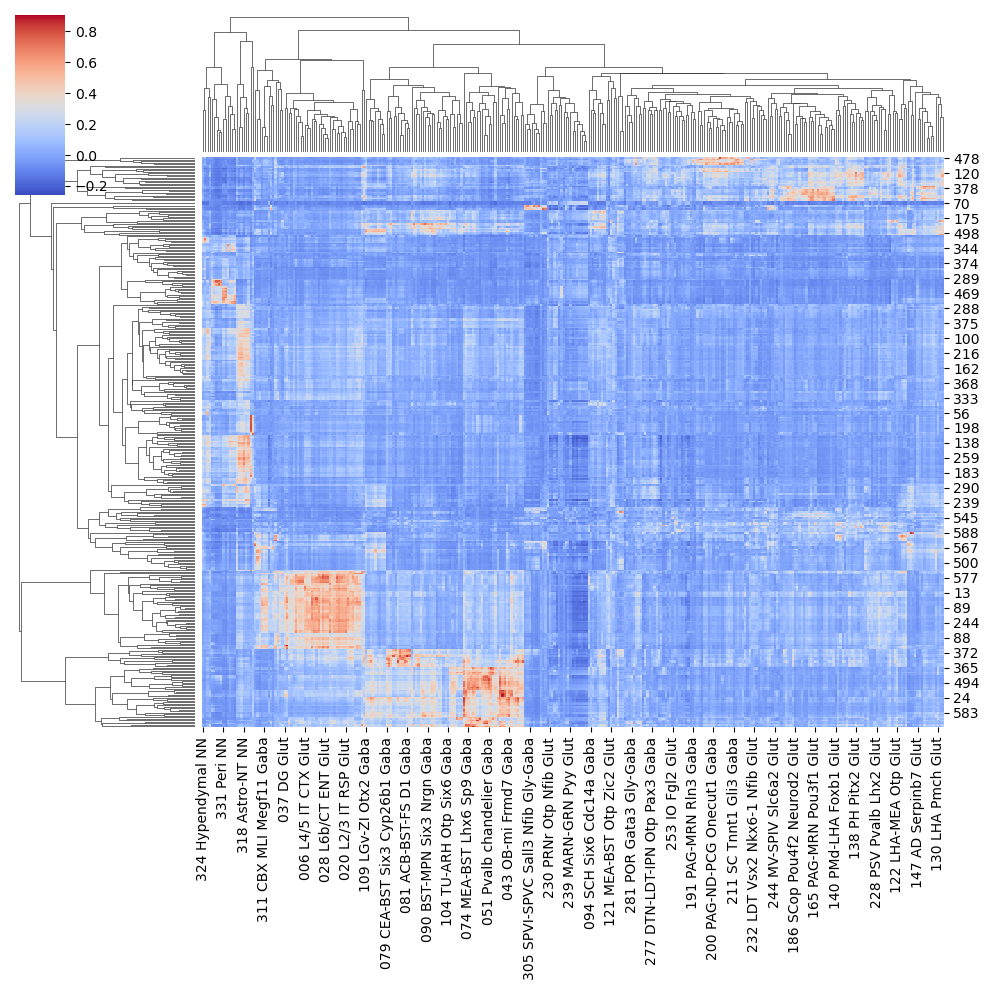

In [55]:
seaborn.clustermap(corrs,cmap='coolwarm')
plt.savefig(os.path.join(sc.settings.figdir,'dev_mouse_juv_mouse_corrs.pdf'))

In [56]:
marker_corr_dict=corrs.idxmax(1).to_dict()

In [57]:
adata.obs['juv_subclass_markercor']=adata.obs[leaf_key].replace(marker_corr_dict)

/scratch/fast/1725836/ipykernel_2805060/799641201.py:1: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  adata.obs['juv_subclass_markercor']=adata.obs[leaf_key].replace(marker_corr_dict)


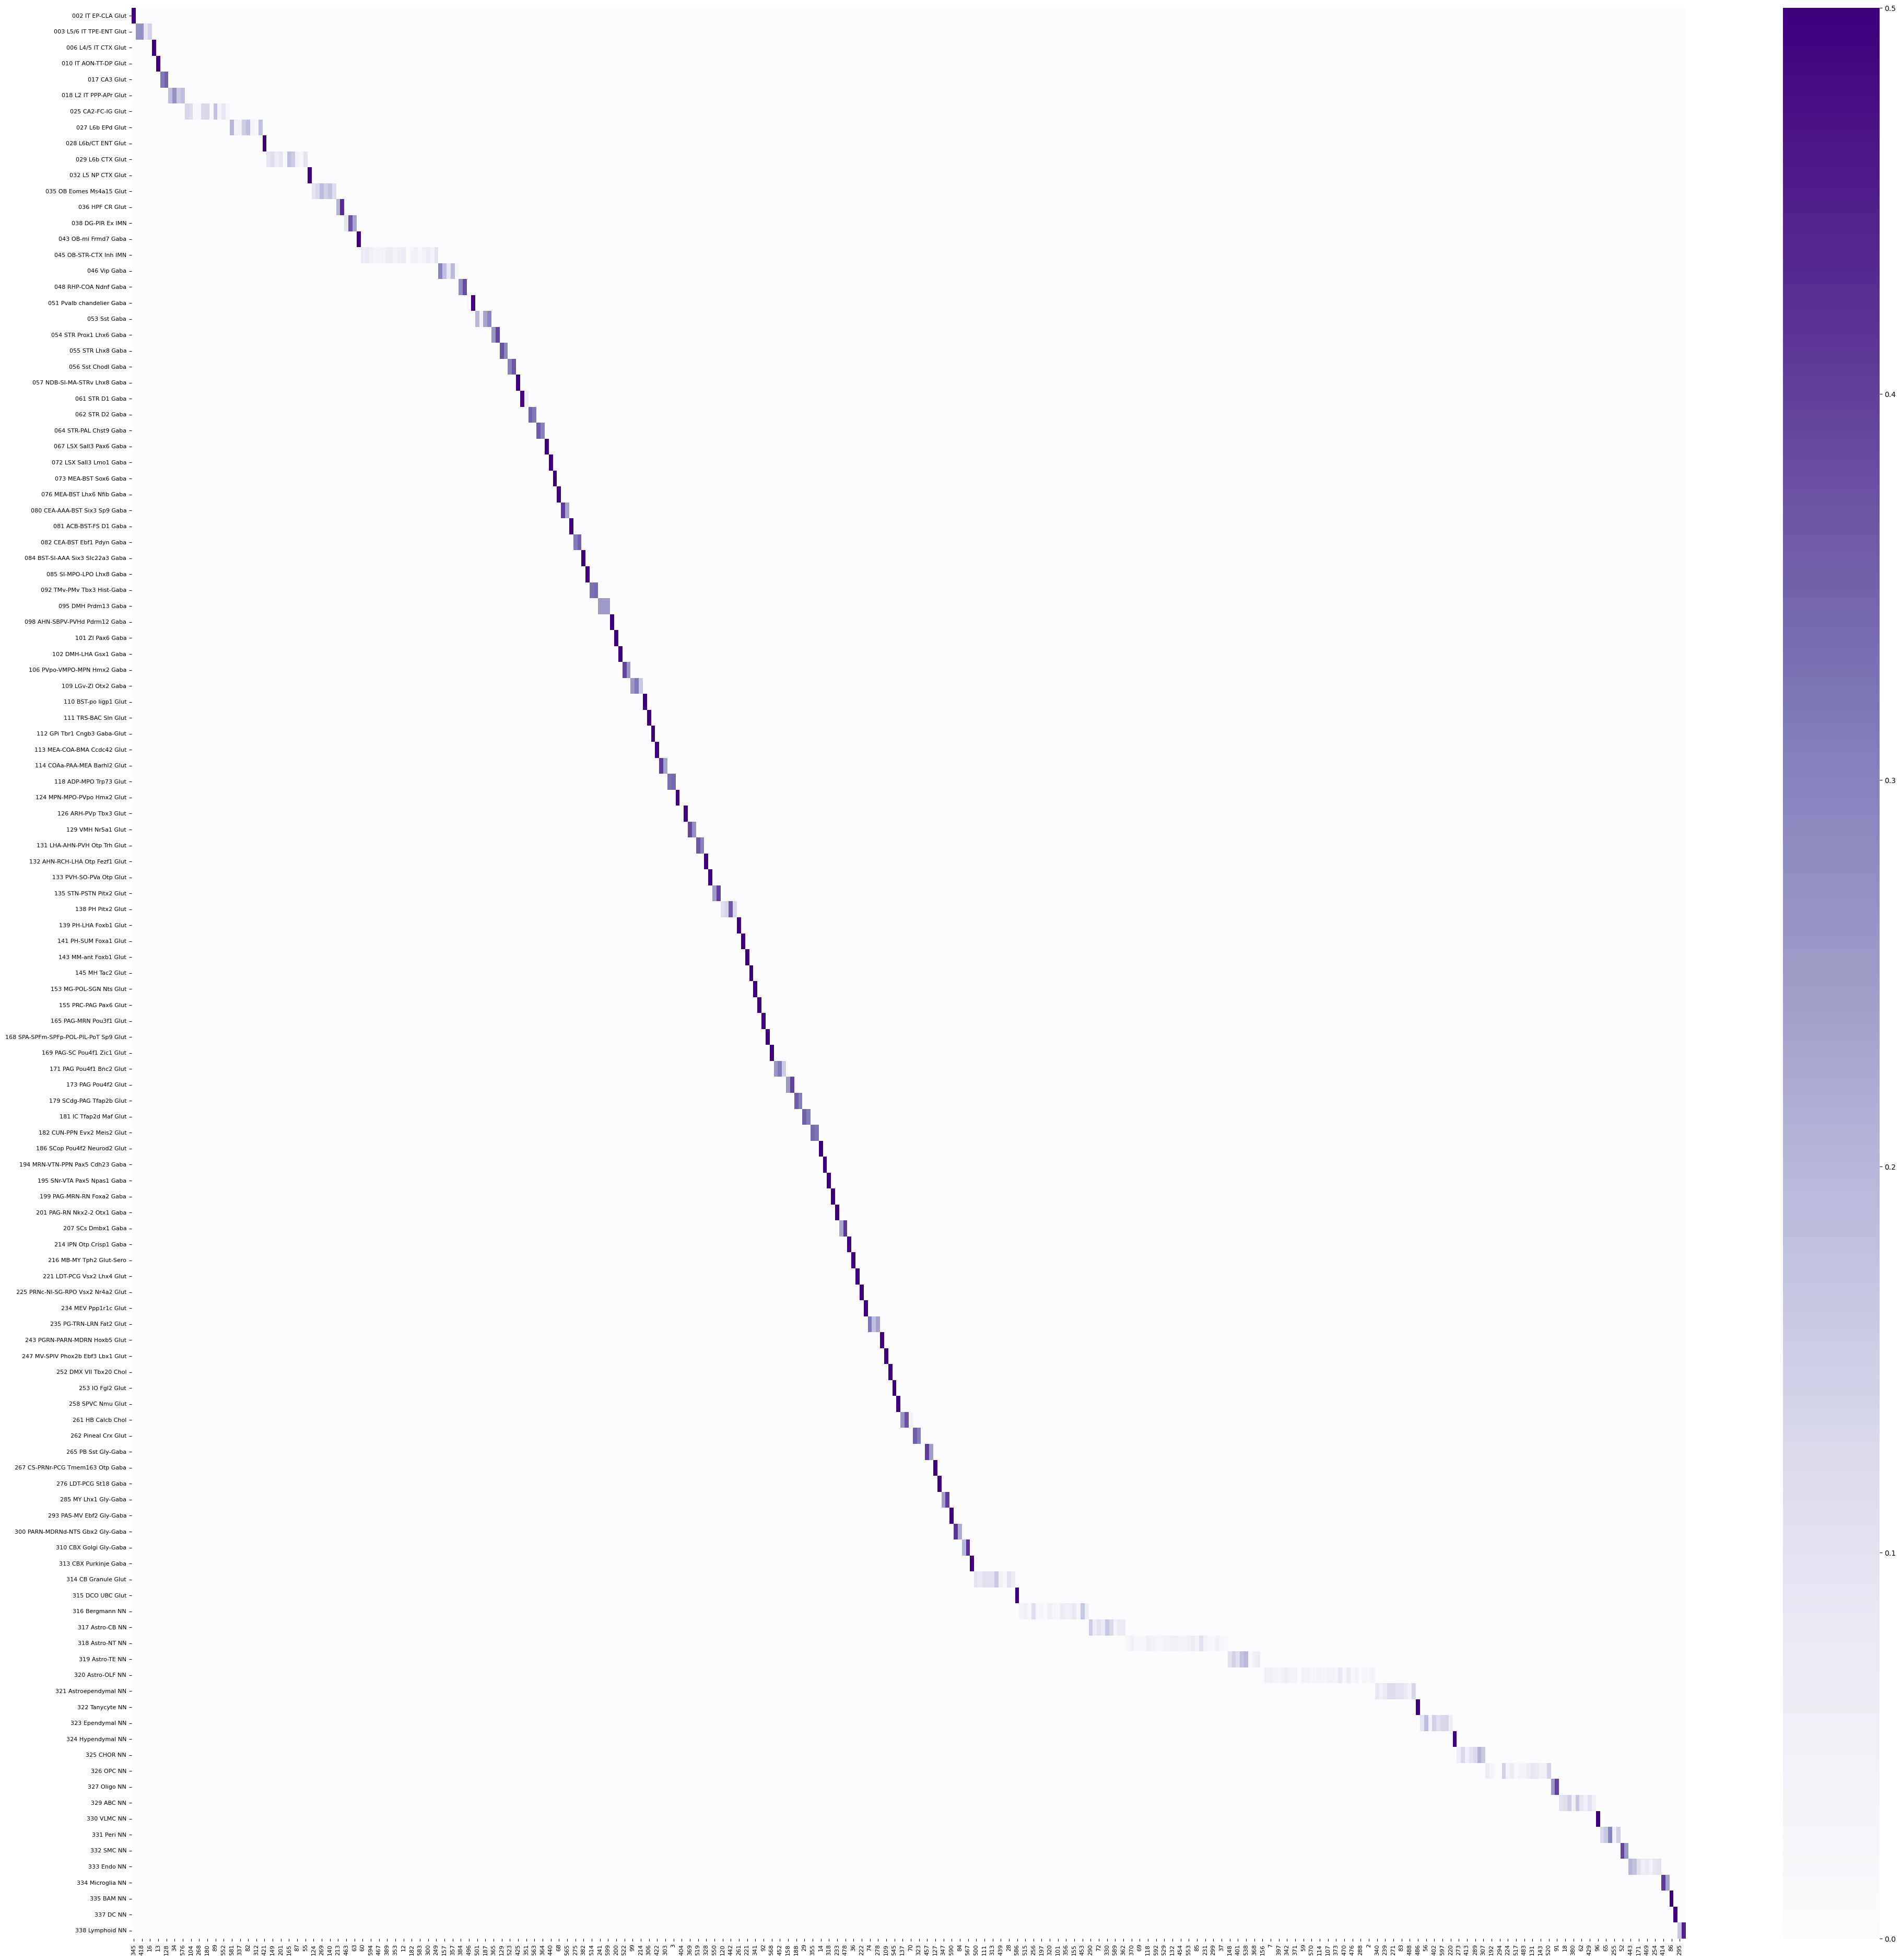

In [58]:
adata.obs['juv_subclass_markercor'] = adata.obs['juv_subclass_markercor'].cat.reorder_categories(sorted(adata.obs['juv_subclass_markercor'].cat.categories))
sc_analysis.create_heatmap(sc_analysis.get_cross_category_jaccard(adata.obs,'juv_subclass_markercor',leaf_key),cmap='Purples')


In [59]:
# adata.uns['species_colors']=[adata.uns['species_color_dict'][x] for x in adata.obs[discov_key].cat.categories]
# sc.pl.embedding(
#     adata,
#     basis=MDE_KEY,
#     color=["species"],
# )

In [60]:
# sc.pl.embedding(
#     adata,
#     basis=MDE_KEY,
#     color=["juv_subclass_markercor"],
#     palette=sc.pl.palettes.godsnot_102,
#     legend_loc='on data',legend_fontsize=5
    
# )
# sc.pl.embedding(
#     adata,
#     basis=MDE_KEY,
#     color=["juv_subclass_markercor"],
#     palette=sc.pl.palettes.godsnot_102
# )

In [61]:
# sc.pl.embedding(
#     adata,
#     basis=MDE_KEY,
#     color=["juv_subclass_markercor",'abc_subclass_markercor'],
#     palette=sc.pl.palettes.godsnot_102,
#     legend_loc='on data',legend_fontsize=5
    
# )

# sc.pl.embedding(
#     adata,
#     basis=MDE_KEY,
#     color=["linnarson_extended",leaf_key,'initial_class','ic_extended'],
#     palette=sc.pl.palettes.godsnot_102,
#     legend_loc='on data'
# )

# sc.pl.embedding(
#     adata,
#     basis=MDE_KEY,
#     color=["lamanno_class","lamanno_subclass","lamanno_cluster"],
#     palette=sc.pl.palettes.godsnot_102,
#     legend_loc='on data'
# )



In [62]:
adata.obs.loc[:,[leaf_key,'initial_class','ic_extended','abc_subclass_markercor','juv_subclass_markercor',"linnarson_extended","lamanno_class","lamanno_subclass","lamanno_cluster","female","neighborhood","curated_class_label"]].astype(str).to_csv('/home/matthew.schmitz/Matthew/data/taxtest/annotations/many_mappings3.txt.gz',compression='gzip')